# 2. Modeling

The target is the variable default.
The data has the following structure:

    Observation_id: unique observation id

    Checking_balance: Status of the existing checking account. (German currency)

    Savings_balance: Savings account/bonds (German currency)

    Installment_rate: Installment rate in percentage of disposable income

    Personal_status: Personal status and sex

    Residence_history: Present residence since

    Installment_plan: Other instalment plans

    Existing_credits: Number of existing credits at this bank

    Dependents: Number of people being liable to provide maintenance for

    Default: 0 is a good loan, 1 is a defaulting one.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_precision_recall,plot_cumulative_gain,plot_lift_curve,plot_ks_statistic,plot_calibration_curve
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,RepeatedStratifiedKFold,cross_val_score
from sklearn.metrics import f1_score,confusion_matrix,classification_report,plot_precision_recall_curve,make_scorer
from sklearn.preprocessing import StandardScaler

from skopt import BayesSearchCV

import gc

In [2]:
df=pd.read_csv('credit.csv',index_col=0)

In [3]:
with pd.option_context('display.max_columns',30):
    display(df)

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,residence_history,property,age,installment_plan,housing,existing_credits,default,dependents,telephone,foreign_worker,job,gender
0,-43.0,6,critical,radio/tv,1169,NaN,13 years,4,single,none,6 years,real estate,67,none,own,2,0,1,2.349340e+09,yes,skilled employee,male
1,75.0,48,repaid,radio/tv,5951,89.0,2 years,2,NaN,none,5 months,real estate,22,none,own,1,1,1,NaN,yes,skilled employee,female
2,NaN,12,critical,education,2096,24.0,5 years,2,single,none,4 years,real estate,49,none,own,1,0,2,NaN,yes,unskilled resident,male
3,-32.0,42,repaid,furniture,7882,9.0,5 years,2,single,guarantor,13 years,building society savings,45,none,for free,1,0,2,NaN,yes,skilled employee,male
4,-23.0,24,delayed,car (new),4870,43.0,3 years,3,single,none,13 years,unknown/none,53,none,for free,2,1,2,NaN,yes,skilled employee,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,12,repaid,furniture,1736,48.0,4 years,3,NaN,none,20 years,real estate,31,none,own,1,0,1,NaN,yes,unskilled resident,female
996,-30.0,30,repaid,car (used),3857,20.0,3 years,4,divorced,none,5 years,building society savings,40,none,own,1,0,1,2.340004e+09,yes,mangement self-employed,male
997,NaN,12,repaid,radio/tv,804,44.0,13 years,4,single,none,16 years,other,38,none,own,1,0,1,NaN,yes,skilled employee,male
998,-18.0,45,repaid,radio/tv,1845,31.0,2 years,4,single,none,8 years,unknown/none,23,none,for free,1,1,1,2.342257e+09,yes,skilled employee,male


In [4]:
df.isna().sum()

checking_balance        394
months_loan_duration      0
credit_history            0
purpose                   0
amount                    0
savings_balance         183
employment_length        62
installment_rate          0
personal_status         310
other_debtors             0
residence_history       130
property                  0
age                       0
installment_plan          0
housing                   0
existing_credits          0
default                   0
dependents                0
telephone               596
foreign_worker            0
job                       0
gender                    0
dtype: int64

dropping PII and normalizing employment_length,residence_history to weeks

In [5]:
df.drop('telephone',axis=1,inplace=True)

In [6]:
df['employment_length'].loc[df['employment_length'].str.split(' ',expand=True)[1]=='years']=df['employment_length'].loc[df['employment_length'].str.split(' ',expand=True)[1]=='years'].str.split(' ',expand=True)[0].astype(int)*12
df['employment_length'].loc[df['employment_length'].str.split(' ',expand=True)[1]=='months']=df['employment_length'].loc[df['employment_length'].str.split(' ',expand=True)[1]=='months'].str.split(' ',expand=True)[0].astype(int)
df['employment_length']=df['employment_length'].astype(float)

/home/luv/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
df['residence_history'].loc[df['residence_history'].str.split(' ',expand=True)[1]=='years']=df['residence_history'].loc[df['residence_history'].str.split(' ',expand=True)[1]=='years'].str.split(' ',expand=True)[0].astype(int)*12
df['residence_history'].loc[df['residence_history'].str.split(' ',expand=True)[1]=='months']=df['residence_history'].loc[df['residence_history'].str.split(' ',expand=True)[1]=='months'].str.split(' ',expand=True)[0].astype(int)
df['residence_history']=df['residence_history'].astype(float)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('default',axis=1), df['default'],stratify=df['default'], test_size=0.2,random_state=23)

In [9]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,stratify=y_test, test_size=0.5,random_state=23)

<AxesSubplot:>

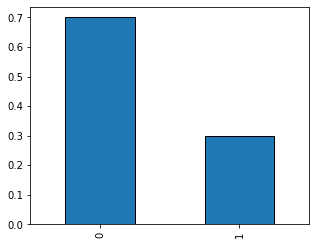

In [10]:
%matplotlib inline
(y_train.value_counts()/len(y_train)).plot.bar(figsize = (5, 4),linewidth = 1,edgecolor='k')

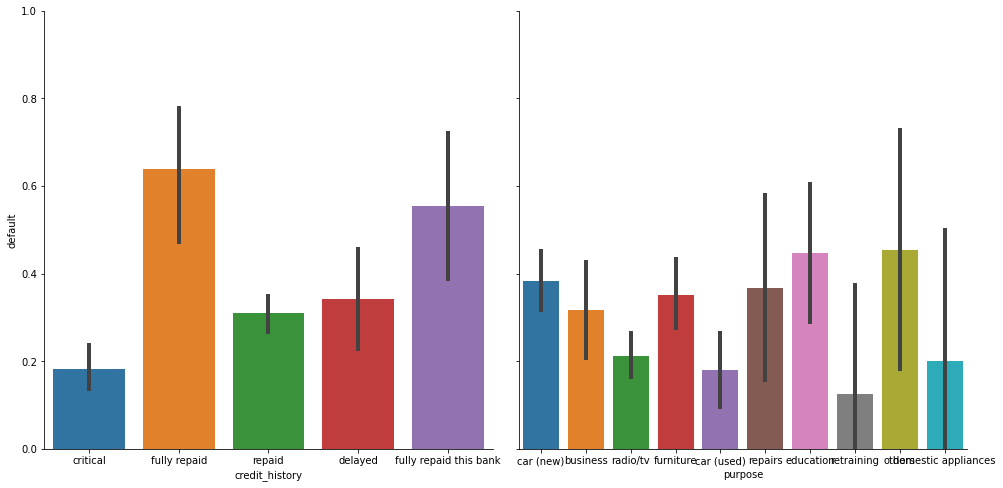

In [11]:
g = sns.PairGrid(X_train.join(y_train),y_vars='default',x_vars=X_train.select_dtypes('O').columns.to_list()[0:2],height=7,layout_pad=1)
g.map(sns.barplot,errwidth=4)
_=g.set(ylim=(0, 1))

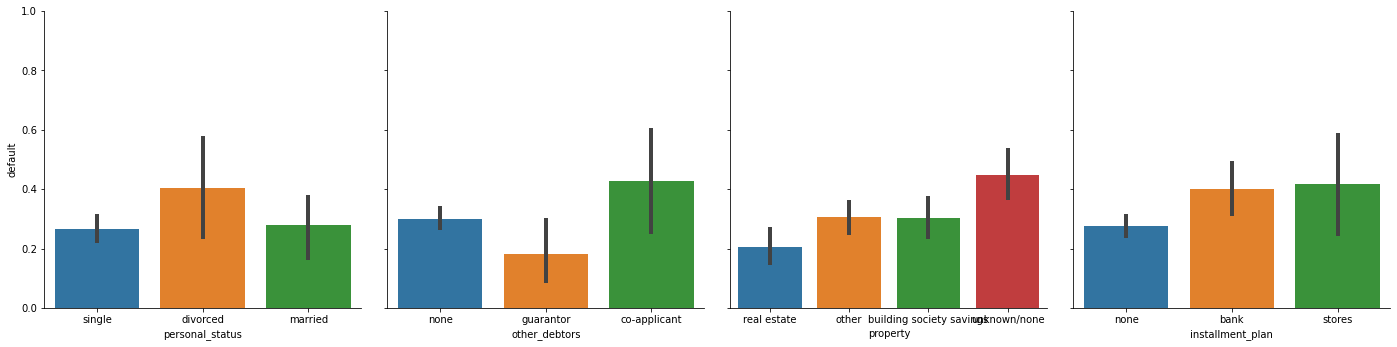

In [12]:
g = sns.PairGrid(X_train.join(y_train),y_vars='default',x_vars=X_train.select_dtypes('O').columns.to_list()[2:6],height=5,layout_pad=1)
g.map(sns.barplot,errwidth=4)
_=g.set(ylim=(0, 1))

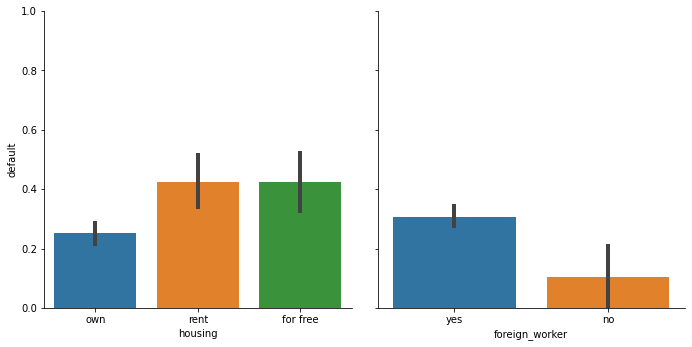

In [13]:
g = sns.PairGrid(X_train.join(y_train),y_vars='default',x_vars=X_train.select_dtypes('O').columns.to_list()[6:8],height=5,layout_pad=1)
g.map(sns.barplot, errwidth=4)
_=g.set(ylim=(0, 1))

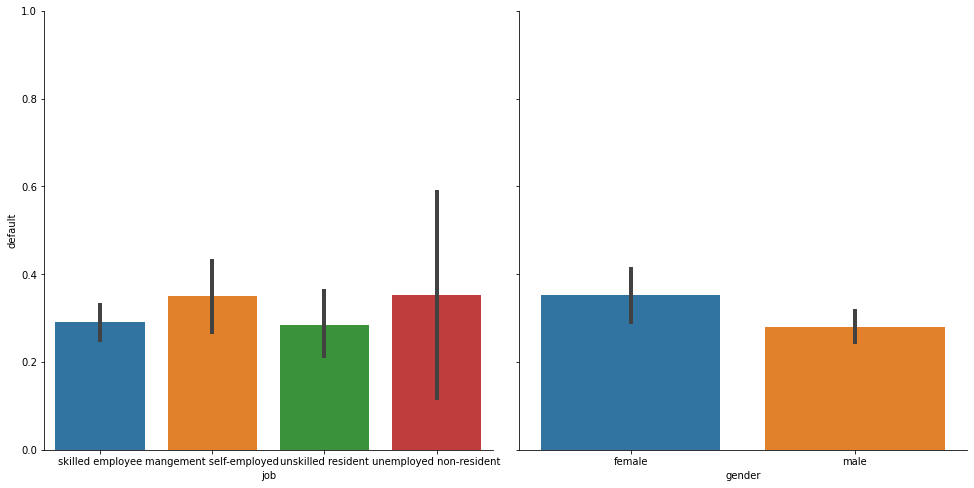

In [14]:
g = sns.PairGrid(X_train.join(y_train),y_vars='default',x_vars=X_train.select_dtypes('O').columns.to_list()[8:],height=7,layout_pad=1,)
g.map(sns.barplot, errwidth=4)
_=g.set(ylim=(0, 1))

In [15]:
del g
gc.collect()

25287

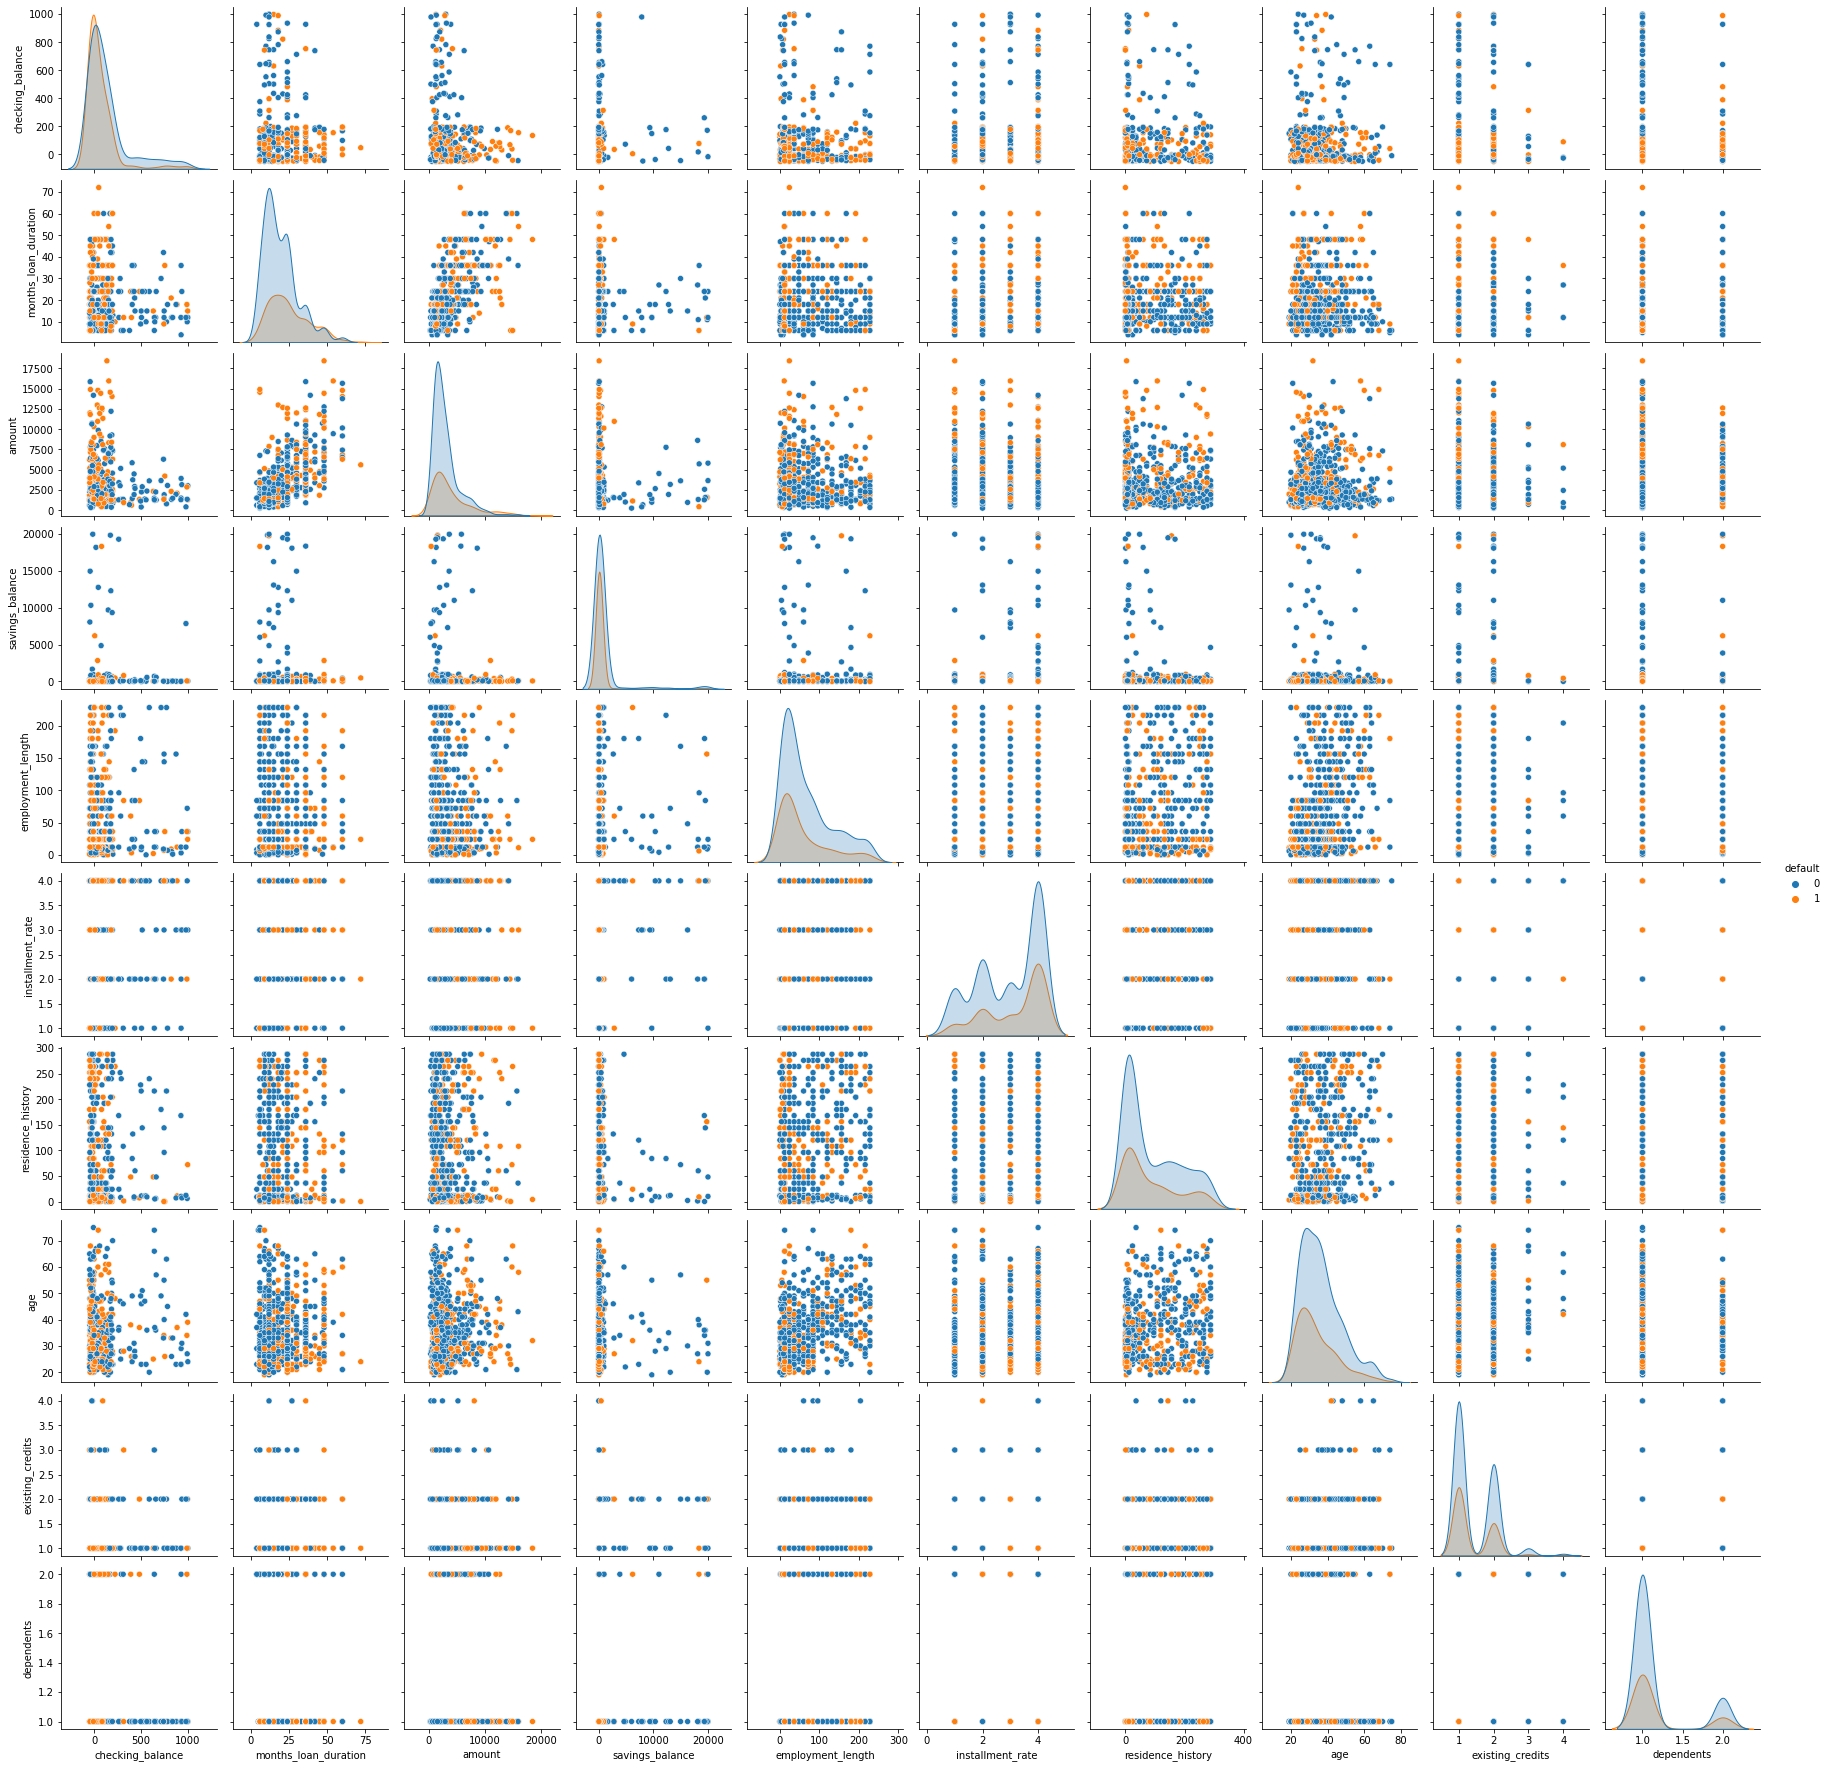

In [16]:
_=sns.pairplot(X_train.join(y_train),dropna=True,hue='default')

There is high class overlap between features

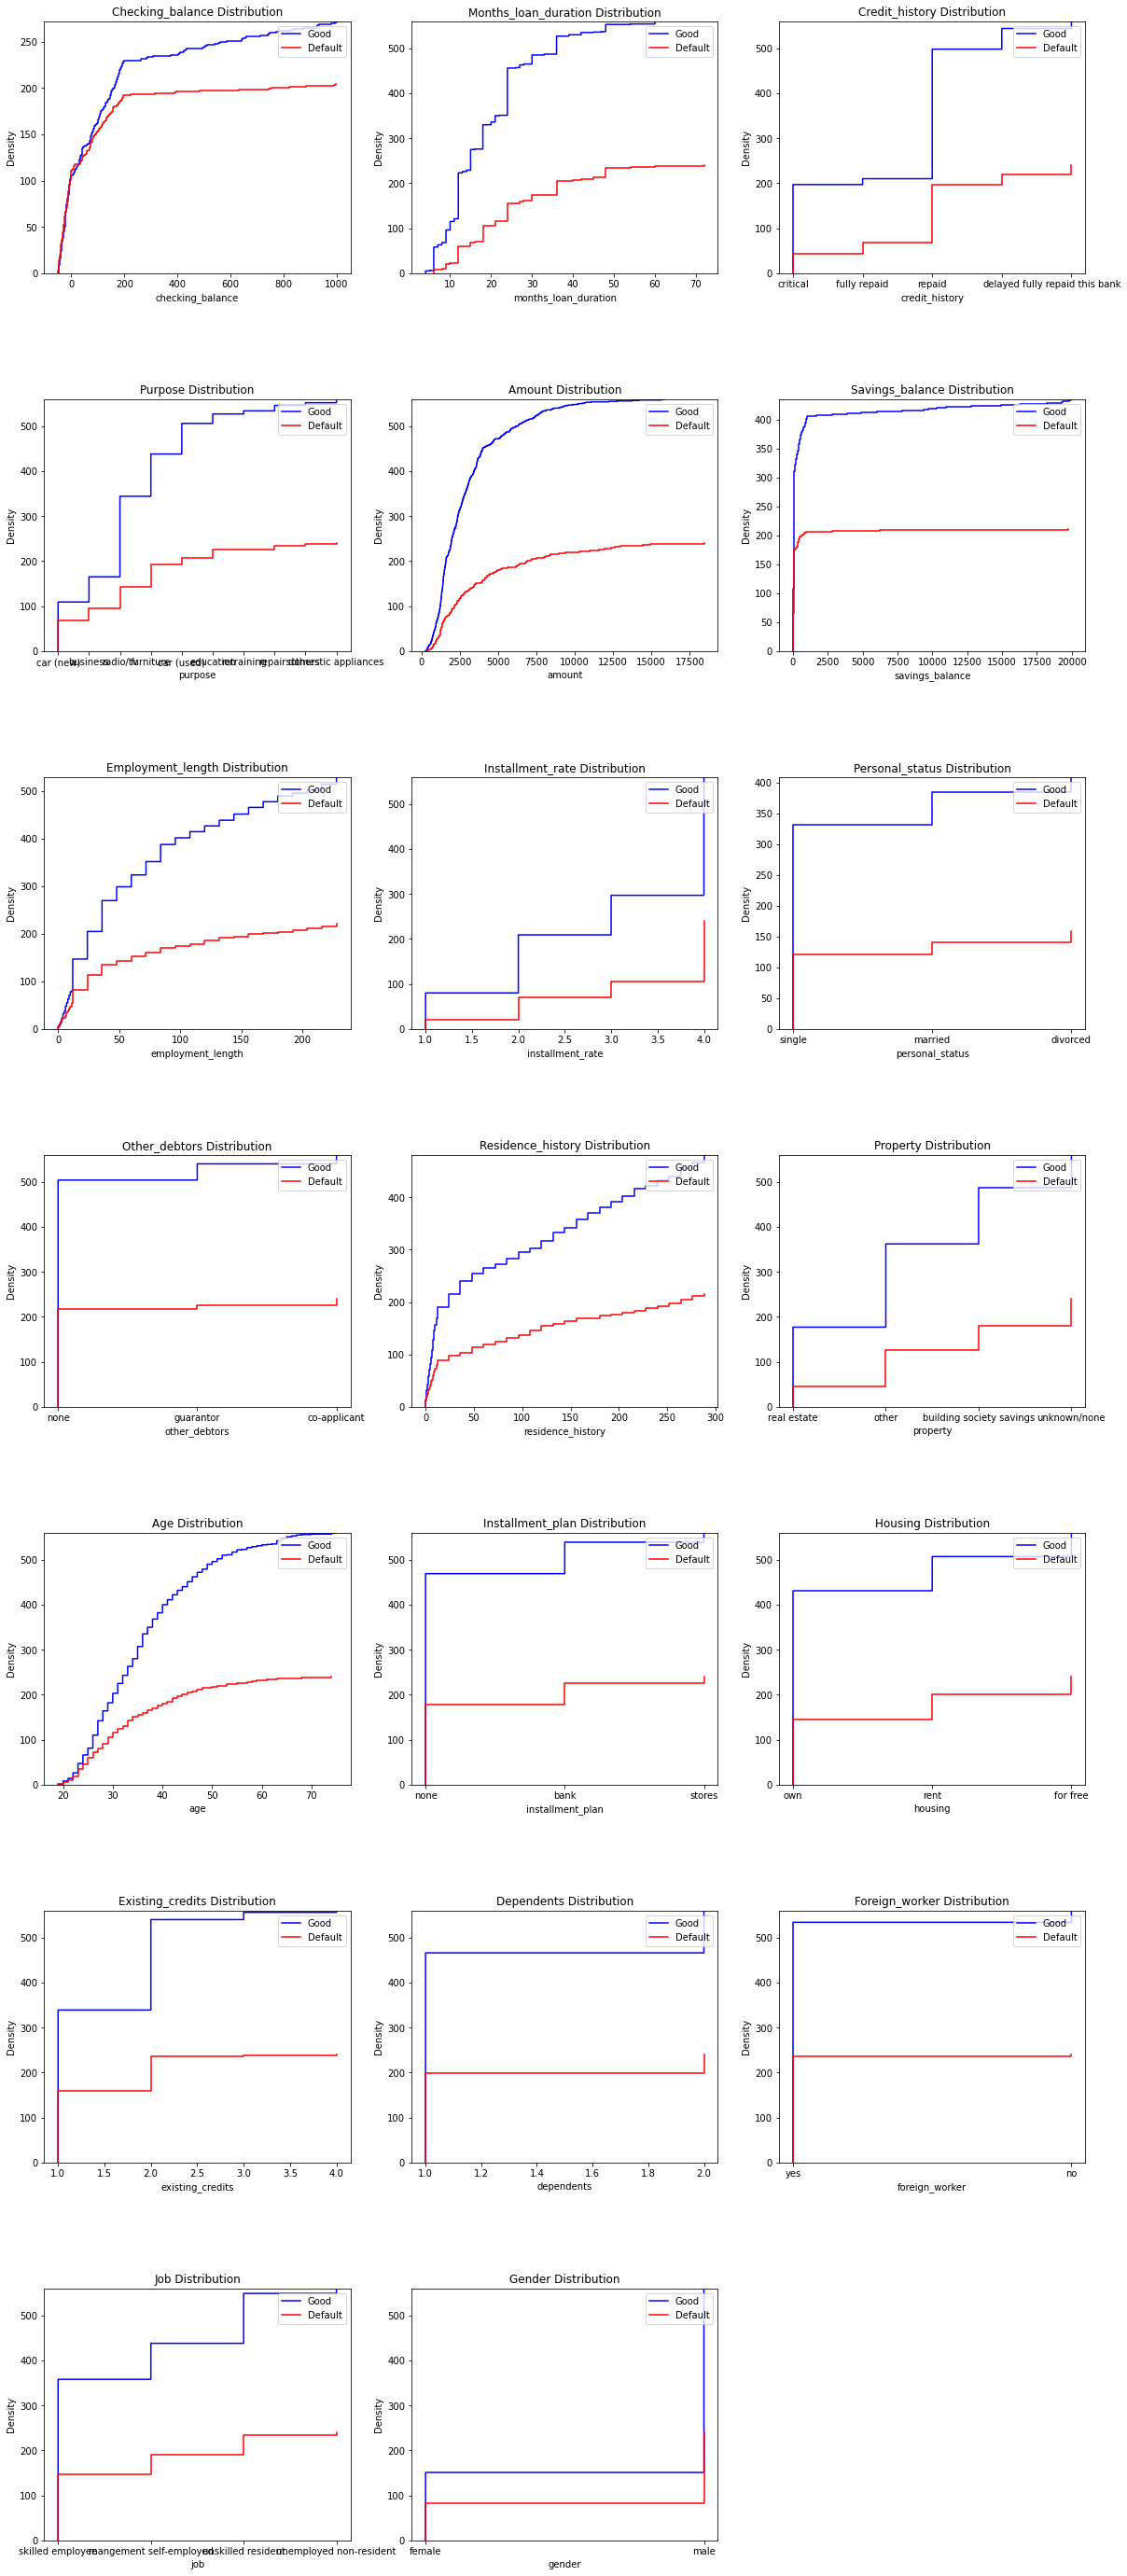

In [17]:
plt.figure(figsize = (20,20))

for i, col in enumerate(X_train):
    ax = plt.subplot(7,3, i+1)
    sns.ecdfplot(X_train.loc[y_train == 0][col].dropna(),stat='count',ax = ax, color = 'b',label='Good')
    sns.ecdfplot(X_train.loc[y_train == 1][col].dropna(),stat='count',ax = ax, color = 'r',label='Default')
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density'); plt.legend(loc="upper right");

    locs, labels = plt.xticks()
plt.subplots_adjust(top = 2, hspace=.5 )

In [18]:
gc.collect()

193

# Modeling

Helper functions

In [19]:
#function to convert variables into categorical and numerical features
def convert_var_by_type(df,discrete_len=0):
    categorical = [var for var in df.columns if df[var].dtype=='O'] # get all categorical variable
    numerical = [var for var in df.columns if df[var].dtype!='O'] # get all numerical variable
    discrete = []
    continous=[]
    for var in numerical:
            if len(df[var].unique())<=discrete_len:
                discrete.append(var) # identify all discrete columns
            else:
                continous.append(var) # identify all continous columns
    return categorical, discrete, continous, numerical


In [20]:
def add_nullcol(df):
    for n,c in df.items():
        if pd.isnull(c).sum():
            df[n+'_na'] = pd.isnull(c)

## Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
categorical,_,_, numerical=convert_var_by_type(X_train)

In [23]:
X_lr_train=X_train.copy()
X_lr_val=X_val.copy()

In [24]:
add_nullcol(X_lr_train)
add_nullcol(X_lr_val)

In [25]:
X_lr_train.loc[:, numerical]=X_lr_train.loc[:, numerical].fillna(X_lr_train.loc[:, numerical].median())
X_lr_val.loc[:, numerical]=X_lr_val.loc[:, numerical].fillna(X_lr_train.loc[:, numerical].median())

X_lr_train.loc[:, categorical]=X_lr_train.loc[:, categorical].fillna('UNK')
X_lr_val.loc[:, categorical]=X_lr_val.loc[:, categorical].fillna('UNK')

In [26]:
a={n:dict(enumerate(X_lr_train[n].astype("category").cat.categories )) for n in categorical}

In [27]:
for key,val in a.items():
    X_lr_train[key]=X_lr_train[key].replace(val.values(),val.keys())
    X_lr_val[key]=X_lr_val[key].replace(val.values(),val.keys())

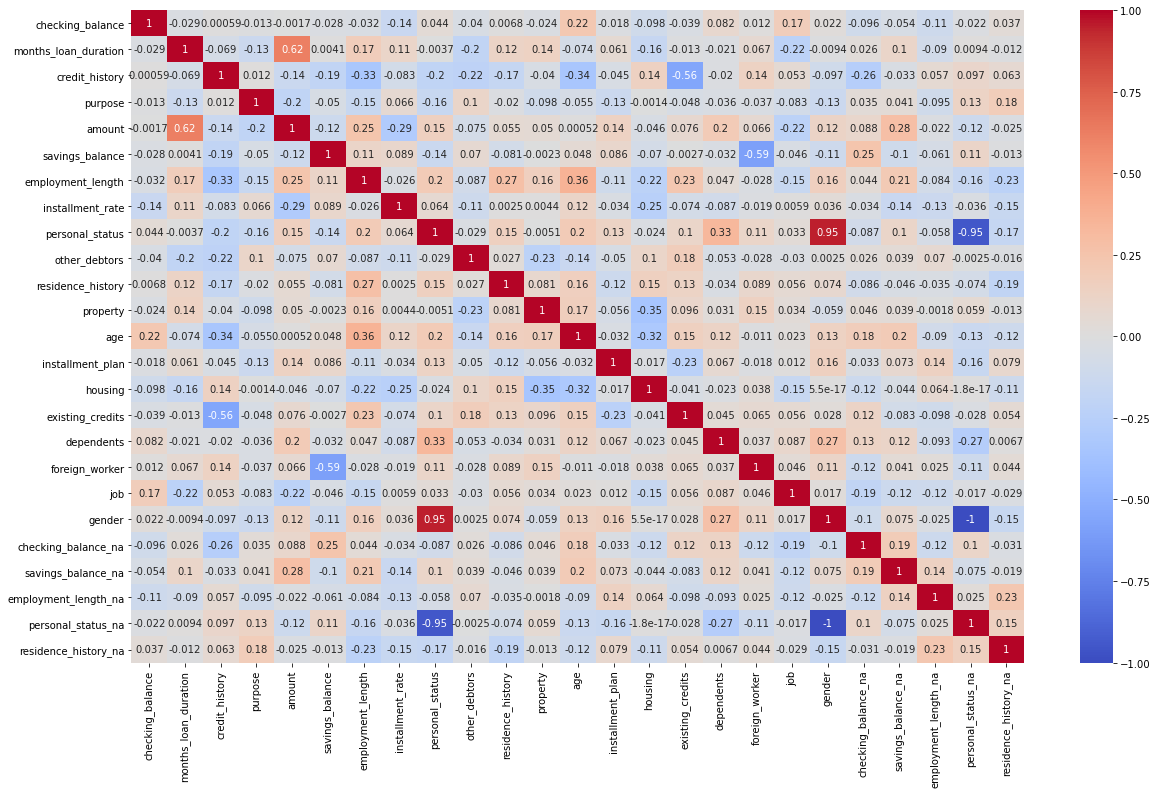

In [28]:
cor = X_lr_val.corr()
plt.figure(figsize=(20,12))
_=sns.heatmap(cor,cmap='coolwarm',annot=True)

In [29]:
del cor

1. it seems we added 'UNK' as a category for personal status where it was NA,as well as an extra column we will have to delete it.
2. gender seems to have high correlation with pesonal status,lets verifiy it

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
[(variance_inflation_factor(X_lr_train.assign(const=1).astype(float).values, i),X_lr_train.assign(const=1).columns[i]) for i in range(X_lr_train.assign(const=1).shape[1])]

/home/luv/miniconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/luv/miniconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


[(1.096023220348101, 'checking_balance'),
 (1.894010600054359, 'months_loan_duration'),
 (1.6124451170756653, 'credit_history'),
 (1.1043748559636022, 'purpose'),
 (2.148734521107403, 'amount'),
 (1.0397335957998963, 'savings_balance'),
 (1.3371435449247797, 'employment_length'),
 (1.330543591169622, 'installment_rate'),
 (7.868104187011155, 'personal_status'),
 (1.0870407188373357, 'other_debtors'),
 (1.1611430160985676, 'residence_history'),
 (1.1870825133349012, 'property'),
 (1.3281636927679166, 'age'),
 (1.0304074367642104, 'installment_plan'),
 (1.3640079445010274, 'housing'),
 (1.5970418302047094, 'existing_credits'),
 (1.1656622008333861, 'dependents'),
 (1.0723098800256166, 'foreign_worker'),
 (1.1787881818491603, 'job'),
 (inf, 'gender'),
 (1.168539810226333, 'checking_balance_na'),
 (1.085582698859563, 'savings_balance_na'),
 (1.1115527282132425, 'employment_length_na'),
 (inf, 'personal_status_na'),
 (1.0842260465690727, 'residence_history_na'),
 (0.0, 'const')]

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
[(variance_inflation_factor(X_lr_train.drop(['gender','personal_status_na'],axis=1).assign(const=1).astype(float).values, i),X_lr_train.drop(['gender','personal_status_na'],axis=1).assign(const=1).columns[i]) for i in range(X_lr_train.drop(['gender','personal_status_na'],axis=1).assign(const=1).shape[1])]

[(1.0958947257563565, 'checking_balance'),
 (1.894005160654281, 'months_loan_duration'),
 (1.6124394888813143, 'credit_history'),
 (1.1043748200320396, 'purpose'),
 (2.145098683920675, 'amount'),
 (1.039076070835793, 'savings_balance'),
 (1.3367767111030355, 'employment_length'),
 (1.3248459069956966, 'installment_rate'),
 (1.212285820366729, 'personal_status'),
 (1.0862894864463406, 'other_debtors'),
 (1.1550293576643575, 'residence_history'),
 (1.1860082675663928, 'property'),
 (1.3267547475474515, 'age'),
 (1.0301256583777394, 'installment_plan'),
 (1.3631407679241747, 'housing'),
 (1.5970271625187566, 'existing_credits'),
 (1.154502361587087, 'dependents'),
 (1.0723031996582715, 'foreign_worker'),
 (1.1774463067037784, 'job'),
 (1.16252622698529, 'checking_balance_na'),
 (1.084310659939524, 'savings_balance_na'),
 (1.1097379037311197, 'employment_length_na'),
 (1.082381982579555, 'residence_history_na'),
 (120.81433586623108, 'const')]

Variable inflation factor also gives us the same results 

In [32]:
X_train['personal_status'][X_train['gender']=='female'].value_counts()

Series([], Name: personal_status, dtype: int64)

It seems there is no personal status for females in our training set  

In [33]:
X_val['personal_status'][X_val['gender']=='female'].value_counts()

Series([], Name: personal_status, dtype: int64)

In [34]:
X_test['personal_status'][X_test['gender']=='female'].value_counts()

Series([], Name: personal_status, dtype: int64)

It is same for test as well as validation set,this column will have to be dropped

In [35]:
X_lr_train.drop(['gender','personal_status_na'],axis=1,inplace=True)
X_lr_val.drop(['gender','personal_status_na'],axis=1,inplace=True)
X_train.drop(['gender'],axis=1,inplace=True)
X_val.drop(['gender'],axis=1,inplace=True)
X_test.drop(['gender'],axis=1,inplace=True)

In [36]:
features=X_lr_train.columns

In [37]:
sc_lr = StandardScaler()
X_lr_train=sc_lr.fit_transform(X_lr_train)
X_lr_val=sc_lr.transform(X_lr_val)

In [38]:
# grid={'C':np.logspace(-5,5,10),
#       'penalty':['l1', 'l2','elasticnet'],
#       'class_weight':['balanced',None],
#       'warm_start':[True,False],
#       'solver':['saga'],
#       'max_iter':[100,200,300]}
# log_class=LogisticRegression()
# logclf=GridSearchCV(log_class,grid,cv=5,n_jobs=-1,scoring='f1_weighted')
# logclf.fit(X_lr_train,y_train)

In [39]:
# print(logclf.best_score_)
# print(logclf.best_params_)

[[61  9]
 [11 19]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        70
           1       0.68      0.63      0.66        30

    accuracy                           0.80       100
   macro avg       0.76      0.75      0.76       100
weighted avg       0.80      0.80      0.80       100



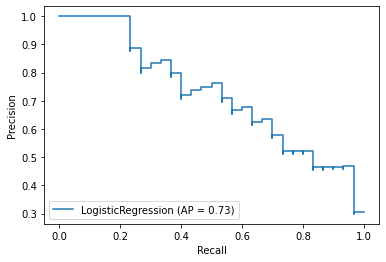

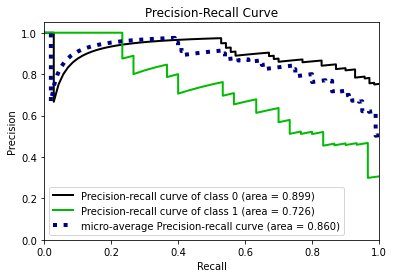

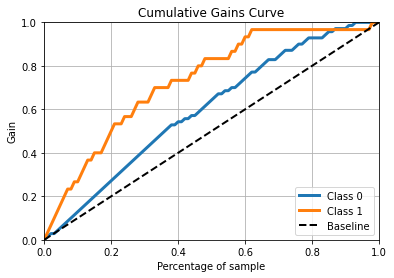

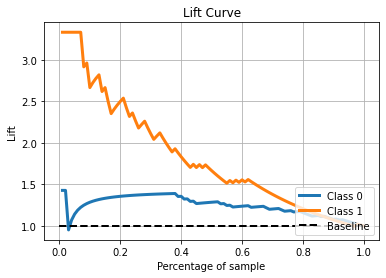

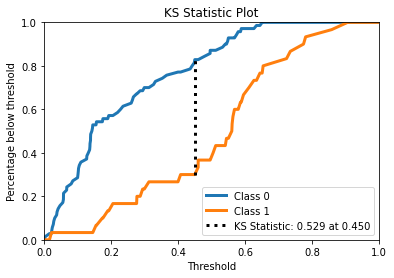

In [40]:
logclf=LogisticRegression(C=3.727593720314938,penalty='l1',solver='saga', warm_start=True)
logclf.fit(X_lr_train,y_train)
y_lr_pred=logclf.predict(X_lr_val)
y_lr_pred_proba=logclf.predict_proba(X_lr_val)
print(confusion_matrix(y_val,y_lr_pred))
print(classification_report(y_val,y_lr_pred))
_=plot_precision_recall_curve(logclf, X_lr_val, y_val)
_= plot_precision_recall(y_val,y_lr_pred_proba)
_=plot_cumulative_gain(y_val,y_lr_pred_proba)
_=plot_lift_curve(y_val,y_lr_pred_proba)
_=plot_ks_statistic(y_val,y_lr_pred_proba)

In [41]:
# for key,val in a.items():
#     print(X_lr_val_plot.key)
#     X_lr_val_plot[:,val]=X_lr_train[:,val].replace(val.keys(),val.values())
#     X_lr_val_plot[:,val]=X_lr_val[:,val].replace(val.keys(),val.values())

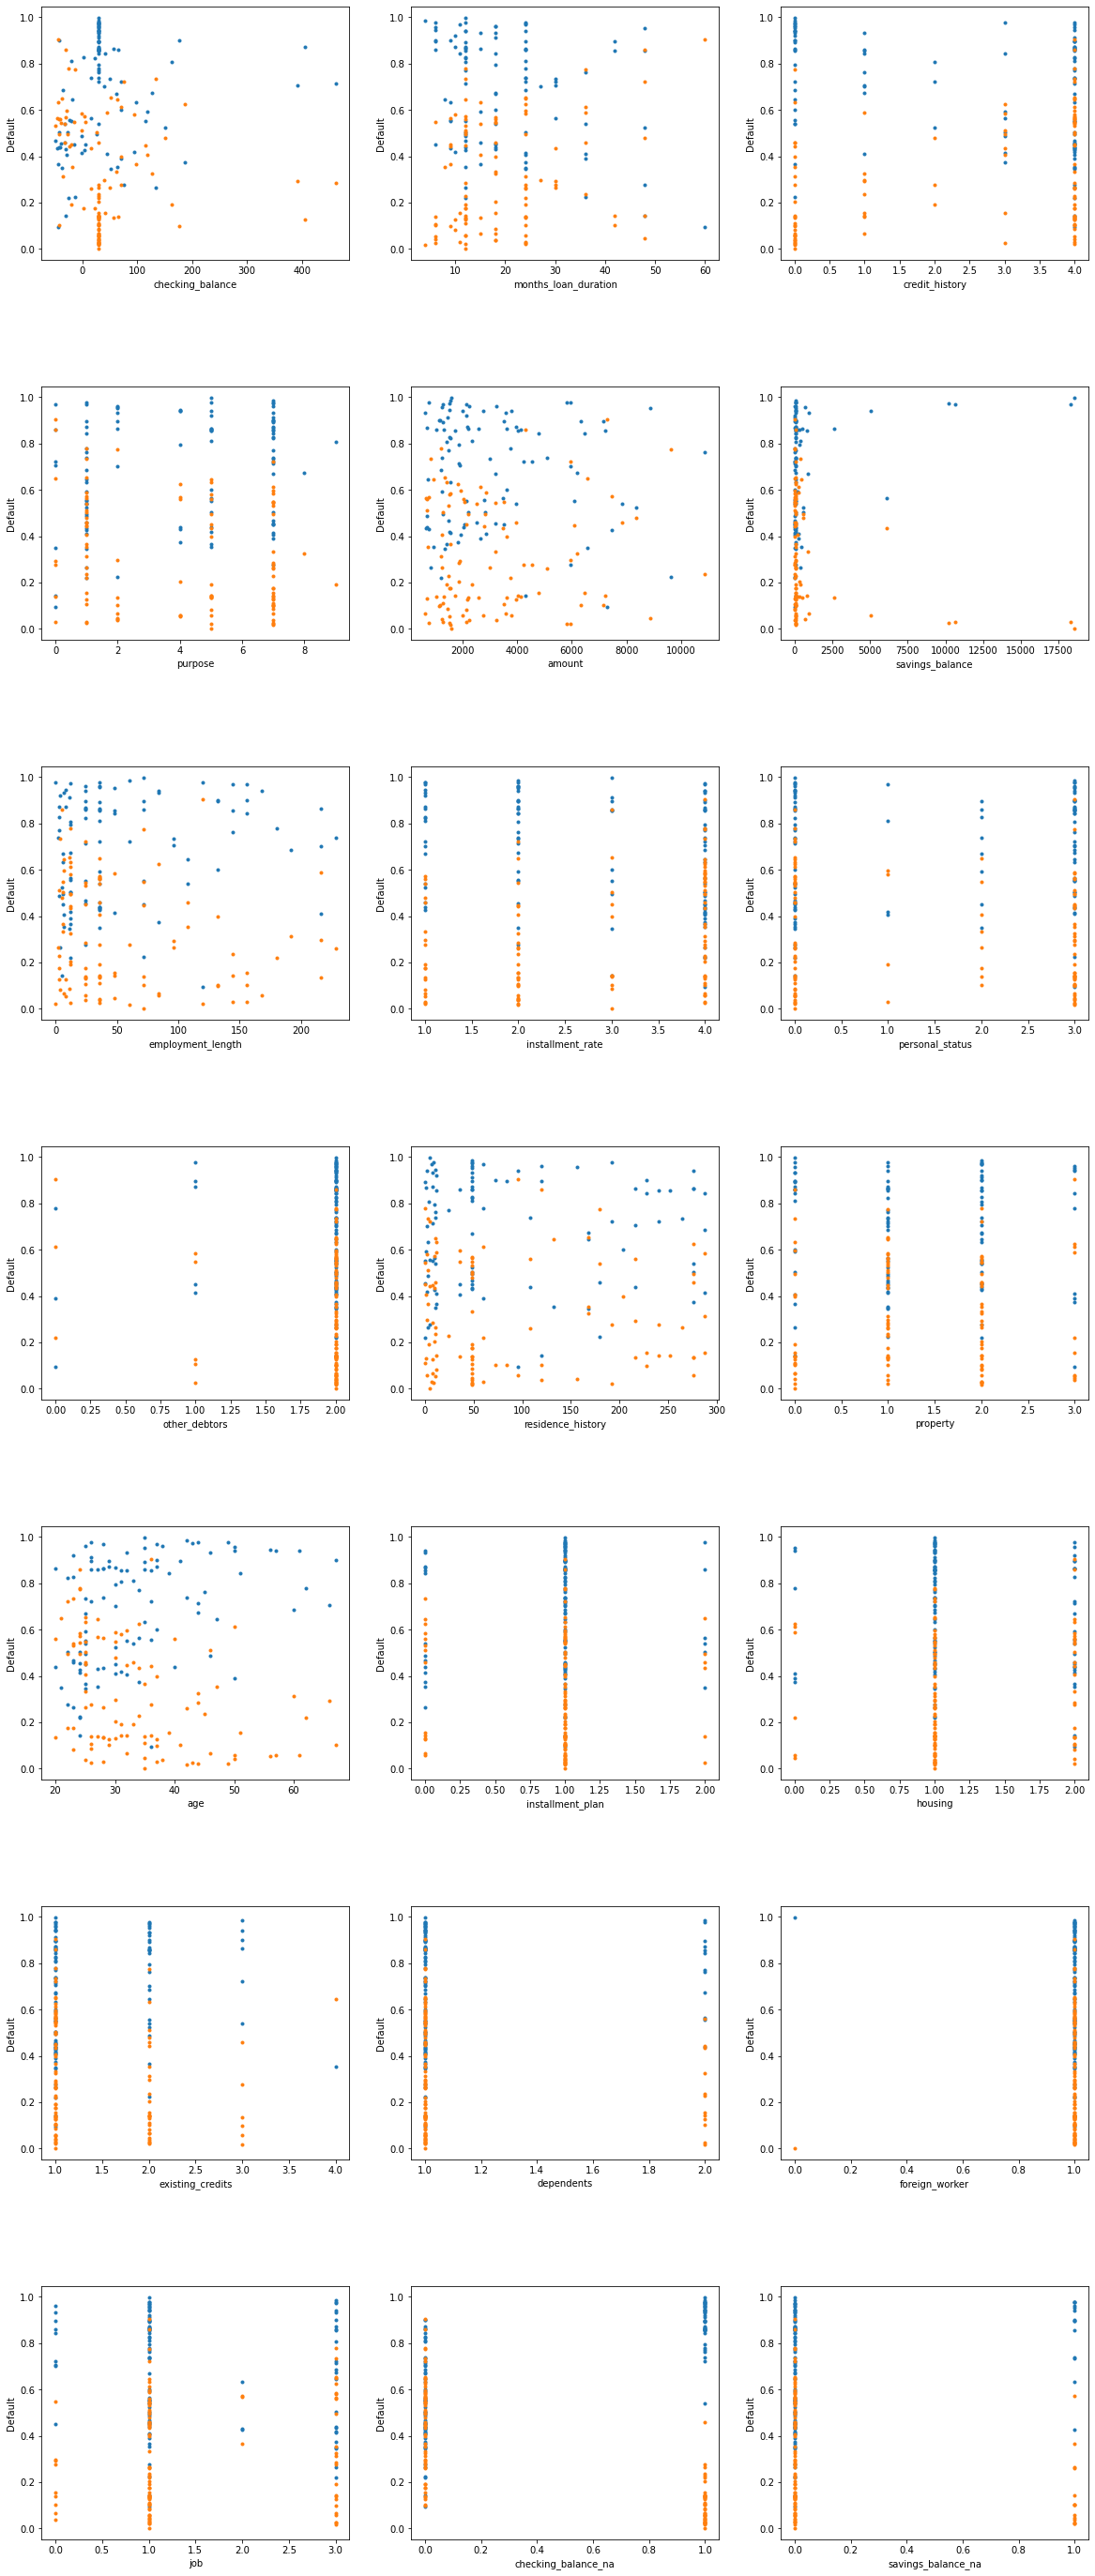

In [42]:
X_lr_val_plot=sc_lr.inverse_transform(X_lr_val)
fig, axes = plt.subplots(7,3,figsize=(20, 20))
for i, ax in enumerate(axes.ravel()):
    ax.plot(X_lr_val_plot[:, i],y_lr_pred_proba,'.')
    ax.set_xlabel(f'{features[i]}')
    ax.set_ylabel("Default")
plt.subplots_adjust(top = 2, hspace=.5 )    

## Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
categorical,_,_, numerical=convert_var_by_type(X_train)

In [45]:
X_rf_train=X_train.copy()
X_rf_val=X_val.copy()

In [46]:
add_nullcol(X_rf_train)
add_nullcol(X_rf_val)

In [47]:
X_rf_train.loc[:, numerical]=X_rf_train.loc[:, numerical].fillna(-999)
X_rf_val.loc[:, numerical]=X_rf_val.loc[:, numerical].fillna(-999)

X_rf_train.loc[:, categorical]=X_rf_train.loc[:, categorical].fillna('UNK')
X_rf_val.loc[:, categorical]=X_rf_val.loc[:, categorical].fillna('UNK')

X_rf_train.drop('personal_status_na',axis=1,inplace=True)
X_rf_val.drop('personal_status_na',axis=1,inplace=True)

In [48]:
a={n:dict(enumerate(X_rf_train[n].astype("category").cat.categories )) for n in categorical}

In [49]:
for key,val in a.items():
    X_rf_train[key]=X_rf_train[key].replace(val.values(),val.keys())
    X_rf_val[key]=X_rf_val[key].replace(val.values(),val.keys())

In [50]:
# grid={'n_estimators': (np.linspace(100,1000, num = 20).astype(int)),
#       'criterion':['gini','entropy'],
#       'max_features': ['auto', 'sqrt', 'log2'],
#       'max_depth': (np.linspace(4, 22, num =18).astype(int)),
#       'class_weight': ['balanced', 'balanced_subsample'],
#       'min_samples_split':(2,4,6,10,15),
#       'min_samples_leaf': (1,2,4,6,8,10)
#      }
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# rfclf=BayesSearchCV(estimator=RandomForestClassifier(random_state=12),search_spaces=grid,scoring='f1_macro',cv=cv,n_jobs=-1)                                       
# rfclf.fit(X_rf_train, y_train)

In [51]:
# print(rfclf.best_score_)
# print(rfclf.best_params_)

[[58 12]
 [ 9 21]]
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        70
           1       0.64      0.70      0.67        30

    accuracy                           0.79       100
   macro avg       0.75      0.76      0.76       100
weighted avg       0.80      0.79      0.79       100

oob_score: 0.74875


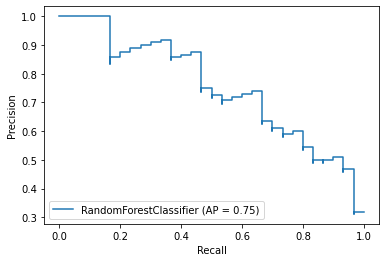

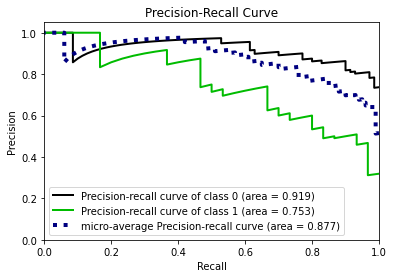

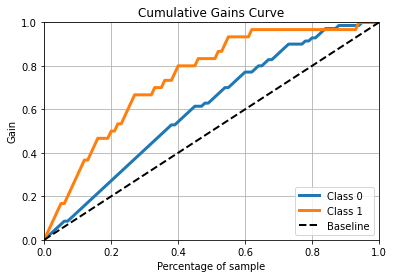

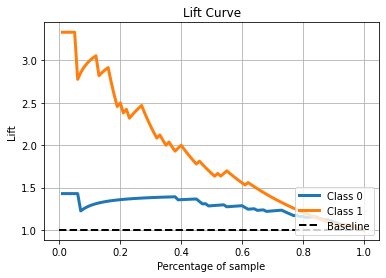

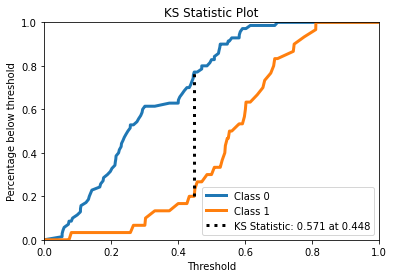

In [52]:
rfclf=RandomForestClassifier(class_weight='balanced_subsample',criterion='gini',max_depth=13,max_features='log2',min_samples_leaf=2,min_samples_split=10,n_estimators=952,oob_score=True)
rfclf.fit(X_rf_train, y_train)
y_rf_pred=rfclf.predict(X_rf_val)
y_rf_pred_proba=rfclf.predict_proba(X_rf_val)
print(confusion_matrix(y_val,y_rf_pred))
print(classification_report(y_val,y_rf_pred))
print(f'oob_score: {rfclf.oob_score_}')
_=plot_precision_recall_curve(rfclf, X_rf_val, y_val)
_= plot_precision_recall(y_val,y_rf_pred_proba)
_=plot_cumulative_gain(y_val,y_rf_pred_proba)
_=plot_lift_curve(y_val,y_rf_pred_proba)
_=plot_ks_statistic(y_val,y_rf_pred_proba)

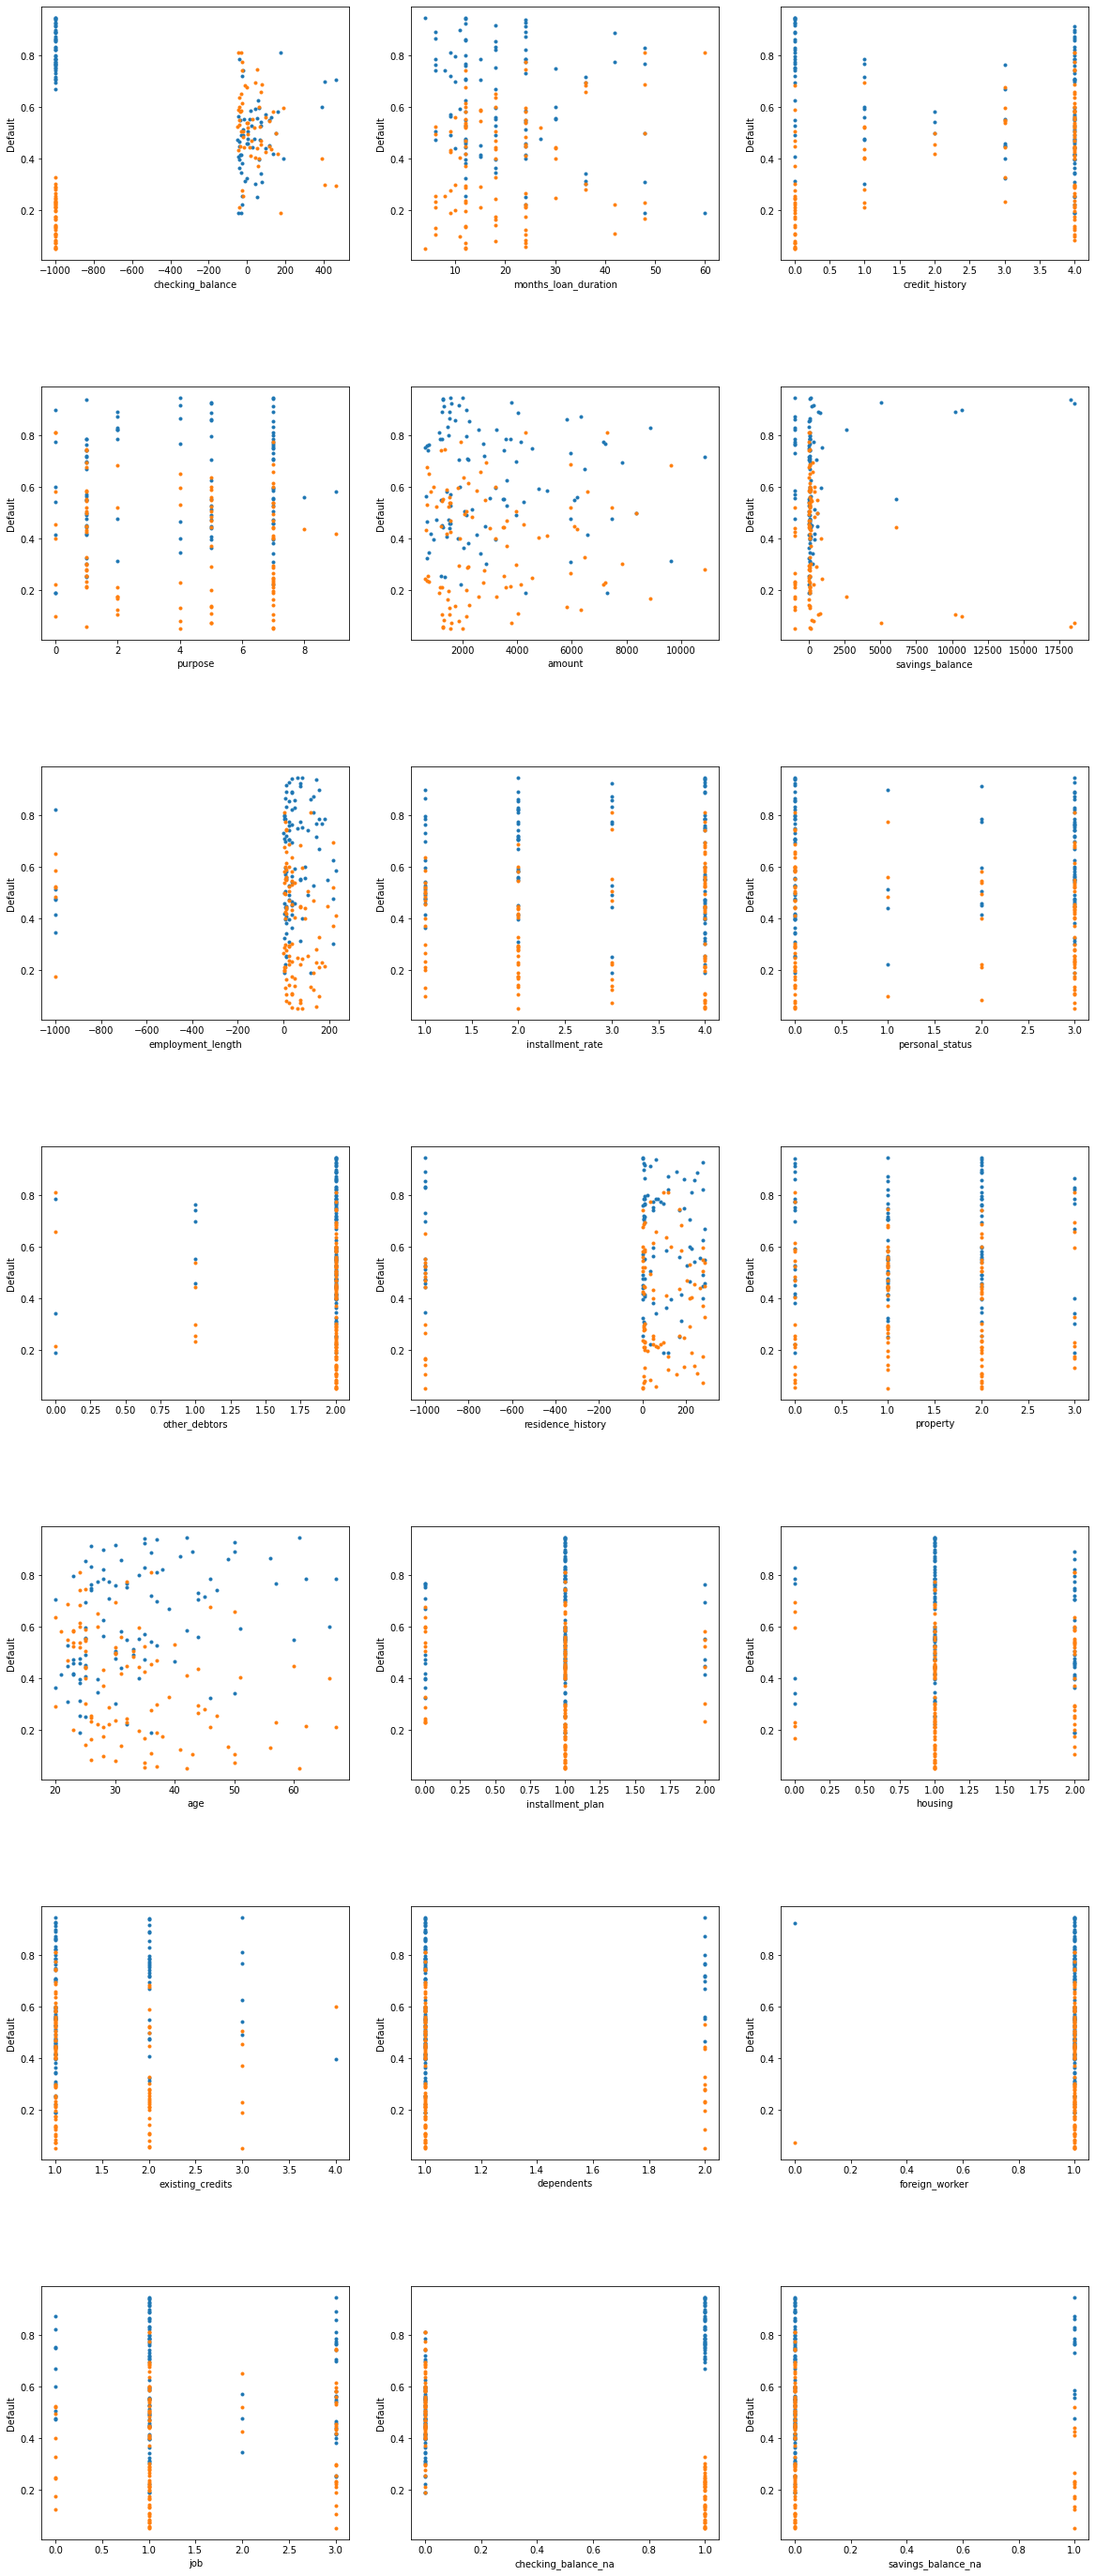

In [53]:
fig, axes = plt.subplots(7,3,figsize=(20, 20))
for i, ax in enumerate(axes.ravel()):
    ax.plot(X_rf_val.iloc[:, i],y_rf_pred_proba,'.')
    ax.set_xlabel(f'{features[i]}')
    ax.set_ylabel("Default")
plt.subplots_adjust(top = 2, hspace=.5 ) 

## SVM

In [54]:
from sklearn.svm import SVC

In [55]:
categorical,_,_, numerical=convert_var_by_type(X_train)

In [56]:
X_SVM_train=X_train.copy()
X_SVM_val=X_val.copy()

In [57]:
add_nullcol(X_SVM_train)
add_nullcol(X_SVM_val)

In [58]:
X_SVM_train.loc[:, numerical]=X_SVM_train.loc[:, numerical].fillna(X_SVM_train.loc[:, numerical].median())
X_SVM_val.loc[:, numerical]=X_SVM_val.loc[:, numerical].fillna(X_SVM_train.loc[:, numerical].median())

X_SVM_train.loc[:, categorical]=X_SVM_train.loc[:, categorical].fillna('UNK')
X_SVM_val.loc[:, categorical]=X_SVM_val.loc[:, categorical].fillna('UNK')

X_SVM_train.drop('personal_status_na',axis=1,inplace=True)
X_SVM_val.drop('personal_status_na',axis=1,inplace=True)

In [59]:
a={n:dict(enumerate(X_SVM_train[n].astype("category").cat.categories )) for n in categorical}

In [60]:
for key,val in a.items():
    X_SVM_train[key]=X_SVM_train[key].replace(val.values(),val.keys())
    X_SVM_val[key]=X_SVM_val[key].replace(val.values(),val.keys())

In [61]:
sc_SVM = StandardScaler()
X_SVM_train=sc_SVM.fit_transform(X_SVM_train)
X_SVM_val=sc_SVM.transform(X_SVM_val)

In [63]:
# grid={'C': (1e-6, 100.0, 'log-uniform'),
#       'gamma':(1e-6, 100.0,'log-uniform'),
#       'class_weight':['balanced',None],
#       'degree':(np.linspace(2,10,8).astype(int)),
#       'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# SVclf = BayesSearchCV(estimator=SVC(random_state=123), search_spaces=grid, n_jobs=-1, cv=cv,scoring='f1_macro',random_state=123)
# SVclf.fit(X_SVM_train,y_train)

In [64]:
# print(SVclf.best_score_)
# print(SVclf.best_params_)

[[49 21]
 [ 6 24]]
              precision    recall  f1-score   support

           0       0.89      0.70      0.78        70
           1       0.53      0.80      0.64        30

    accuracy                           0.73       100
   macro avg       0.71      0.75      0.71       100
weighted avg       0.78      0.73      0.74       100



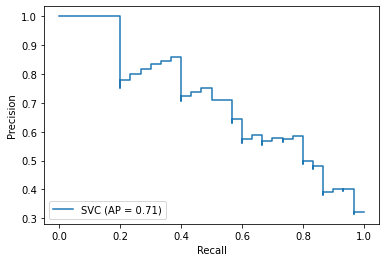

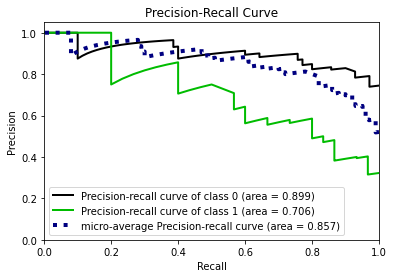

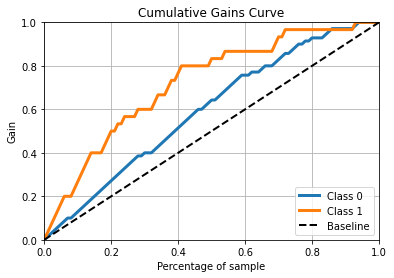

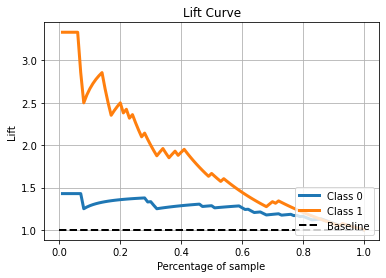

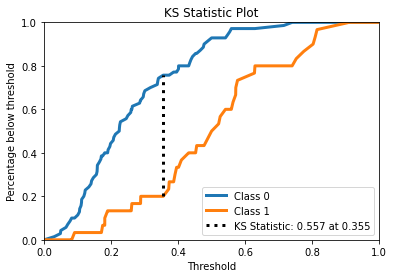

In [65]:
SVclf=SVC(C=100,class_weight='balanced',degree=2,gamma=0.00519398909074211,probability=True,kernel='rbf',random_state=123)
SVclf.fit(X_SVM_train,y_train)
y_SVM_pred=SVclf.predict(X_SVM_val)
y_SVM_pred_proba=SVclf.predict_proba(X_SVM_val)
print(confusion_matrix(y_val,y_SVM_pred))
print(classification_report(y_val,y_SVM_pred))
_=plot_precision_recall_curve(SVclf, X_SVM_val, y_val)
_= plot_precision_recall(y_val,y_SVM_pred_proba)
_=plot_cumulative_gain(y_val,y_SVM_pred_proba)
_=plot_lift_curve(y_val,y_SVM_pred_proba)
_=plot_ks_statistic(y_val,y_SVM_pred_proba)

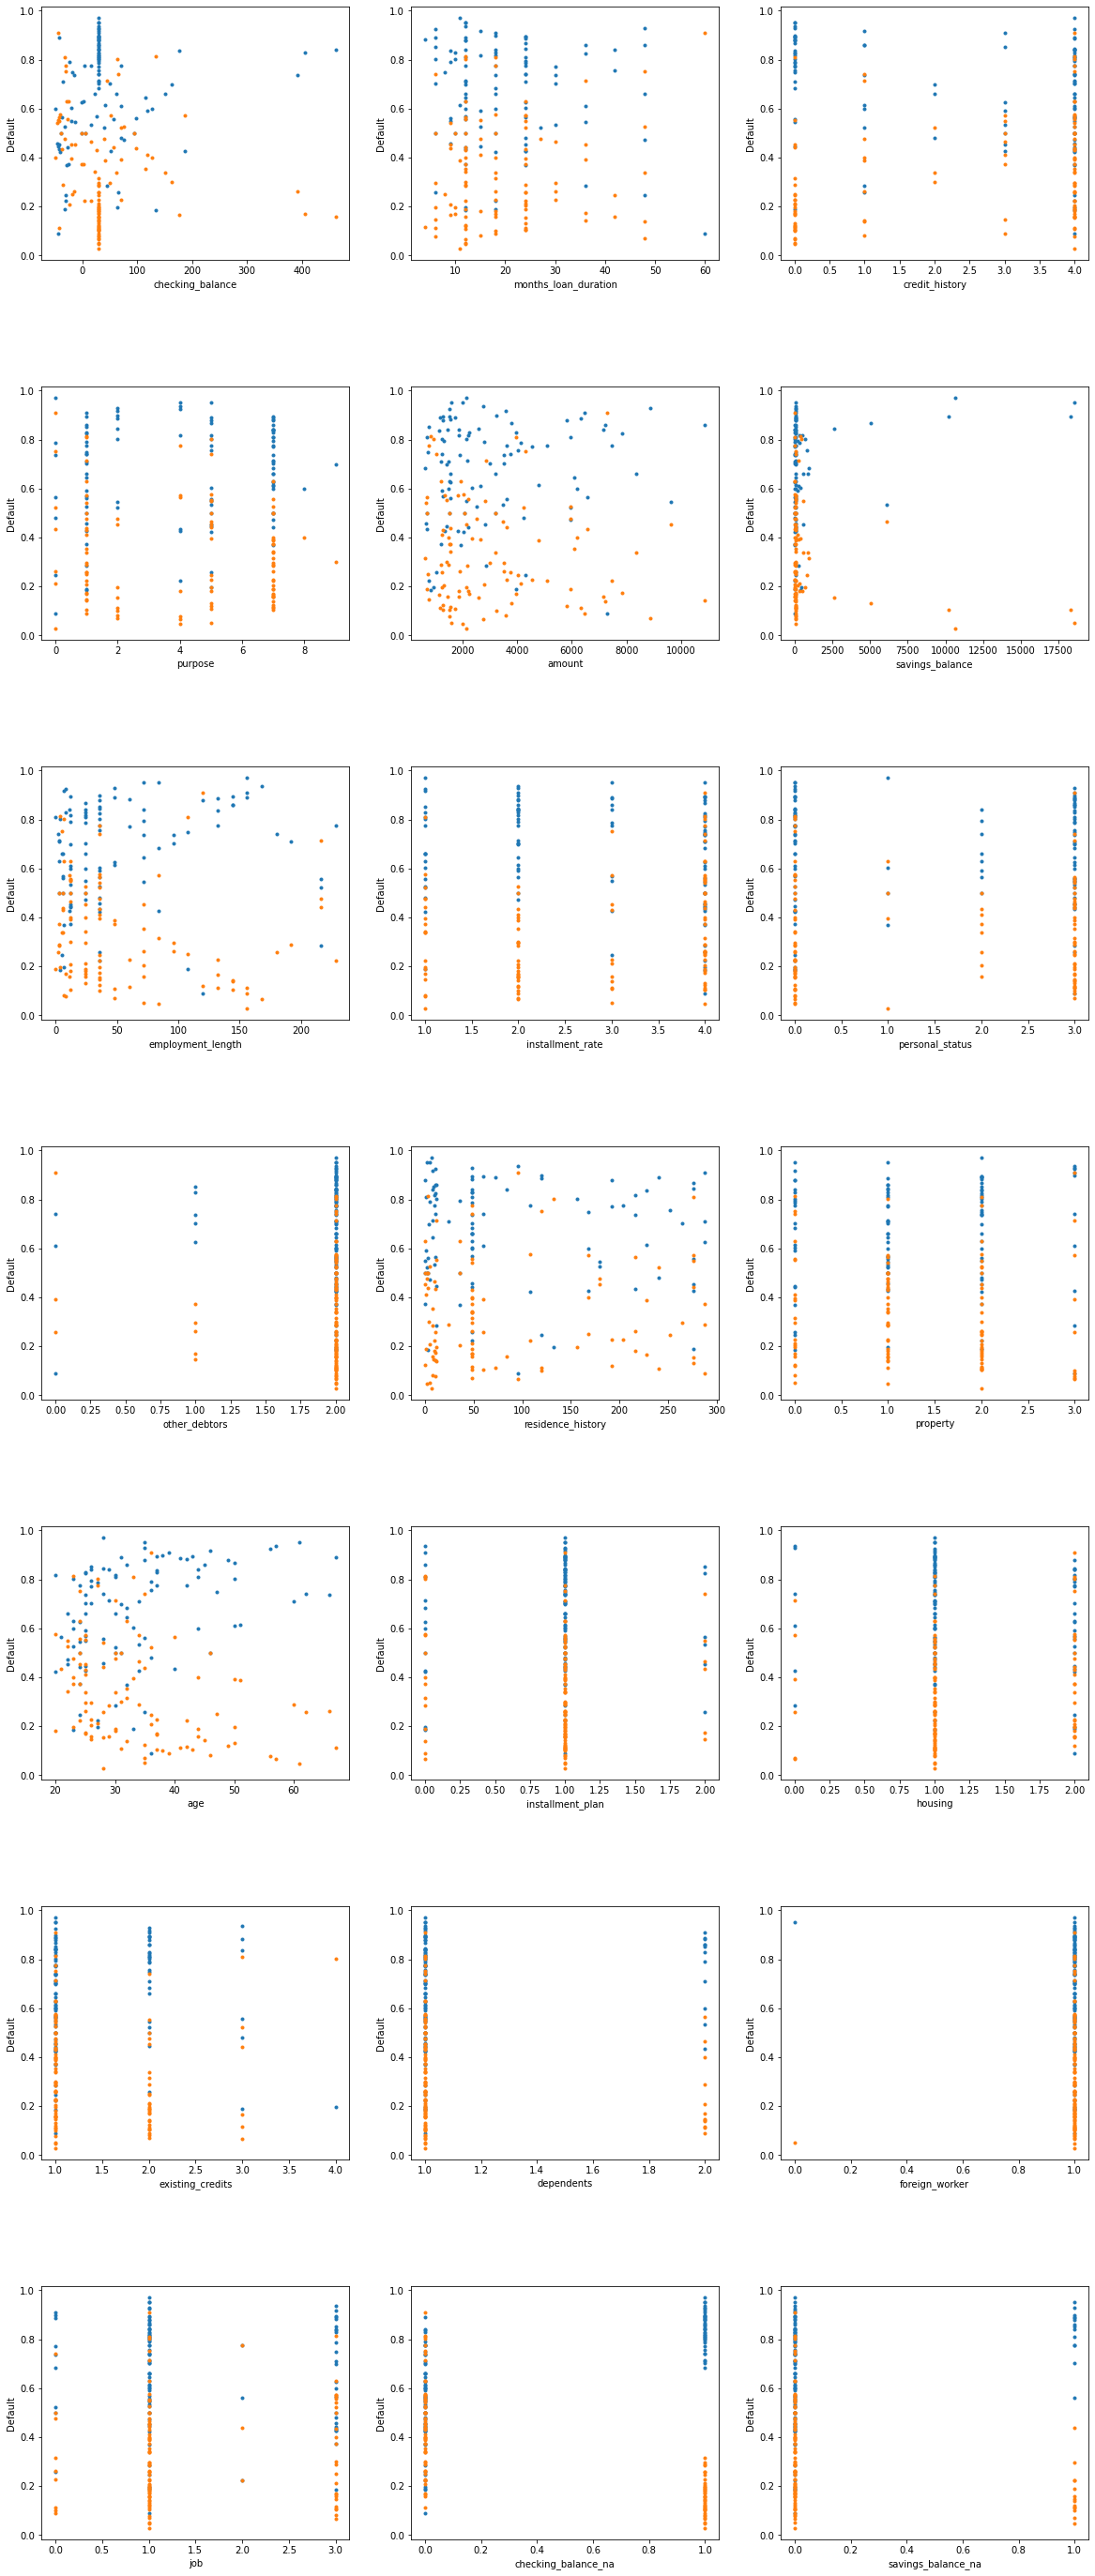

In [66]:
X_SVM_val_plot=sc_lr.inverse_transform(X_SVM_val)
fig, axes = plt.subplots(7,3,figsize=(20, 20))
for i, ax in enumerate(axes.ravel()):
    ax.plot(X_SVM_val_plot[:, i],y_SVM_pred_proba,'.')
    ax.set_xlabel(f'{features[i]}')
    ax.set_ylabel("Default")
plt.subplots_adjust(top = 2, hspace=.5 ) 

In [67]:
gc.collect()

59804

## LGBM

In [68]:
import lightgbm as lgb

In [69]:
categorical,_,_,_=convert_var_by_type(X_train)

In [70]:
X_lgb_train=X_train.copy()
X_lgb_val=X_val.copy()

In [71]:
add_nullcol(X_lgb_train)
add_nullcol(X_lgb_val)
X_lgb_train.drop('personal_status_na',axis=1,inplace=True)
X_lgb_val.drop('personal_status_na',axis=1,inplace=True)

In [72]:
X_lgb_train[categorical] = X_train[categorical].astype('category')
X_lgb_val[categorical] = X_val[categorical].astype('category')

In [73]:
# grid = {
#     'max_bin':list(range(10, 100, 10)),
# #    'scale_pos_weight': [6,7,8],
#     'boosting_type': ['gbdt', 'dart'],
#     'n_estimators':list(range(100, 1000, 100)),
#     'num_leaves': list(range(30, 64, 4)),
#     'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
#     'subsample_for_bin': list(range(20, 500, 200)),
#     'min_child_samples': list(range(20, 50, 5)),
#     'reg_alpha': list(np.linspace(0, 1)),
#     'reg_lambda': list(np.linspace(0, 1)),
#     'colsample_bytree': list(np.linspace(0.6, 1, 10))
# }
# Lgb_estimator=lgb.LGBMClassifier(objective='Binary',is_unbalance=True,categorical_feature=categorical,num_boost_round=3500).set_params(**grid)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Lgbclf = BayesSearchCV(estimator=Lgb_estimator,search_spaces=grid, n_jobs=-1, cv=cv,scoring='f1_macro')
# Lgbclf.fit(X_lgb_train,y_train)

In [74]:
# print(Lgbclf.best_score_)
# print(Lgbclf.best_params_)

/home/luv/miniconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/luv/miniconda3/lib/python3.7/site-packages/lightgbm/basic.py:1224: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
/home/luv/miniconda3/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_feature in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[[60 10]
 [10 20]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        70
           1       0.67      0.67      0.67        30

    accuracy                           0.80       100
   macro avg       0.76      0.76      0.76       100
weighted avg       0.80      0.80      0.80       100



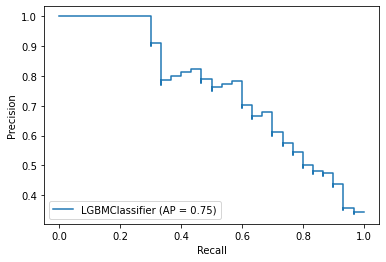

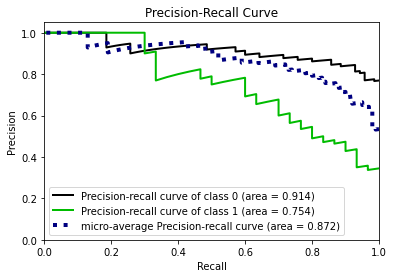

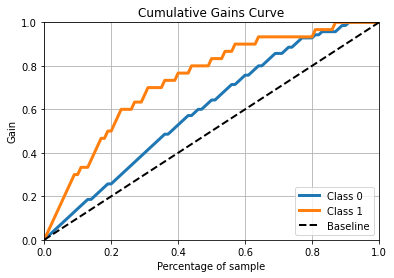

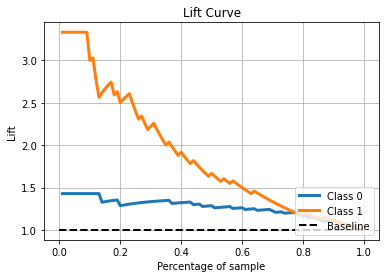

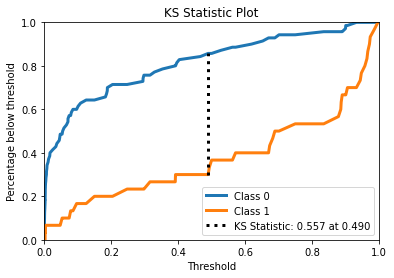

In [75]:
Lgbclf=lgb.LGBMClassifier(objective='Binary',is_unbalance=True,categorical_feature=categorical,num_iterations=3500,boosting_type='gbdt',
                          colsample_bytree= 0.6, learning_rate=  0.010817719303025709, max_bin=70, min_child_samples=20,
                          n_estimators=400, num_leaves=50,reg_alpha= 0.36734693877551017,reg_lambda=0.3877551020408163,subsample_for_bin=220)
Lgbclf.fit(X_lgb_train,y_train)
y_lgb_pred=Lgbclf.predict(X_lgb_val)
y_lgb_pred_proba=Lgbclf.predict_proba(X_lgb_val)
print(confusion_matrix(y_val,y_lgb_pred))
print(classification_report(y_val,y_lgb_pred))
_=plot_precision_recall_curve(Lgbclf, X_lgb_val, y_val)
_= plot_precision_recall(y_val,y_lgb_pred_proba)
_=plot_cumulative_gain(y_val,y_lgb_pred_proba)
_=plot_lift_curve(y_val,y_lgb_pred_proba)
_=plot_ks_statistic(y_val,y_lgb_pred_proba)

In [76]:
gc.collect()

17478

# Model Interpretability and explainability

In [77]:
#Interpretable models
#Model agnostic methods
#Example based explanations
#NN Interpretations

### Feature/Permutation importance Importance

In [78]:
from sklearn.inspection import permutation_importance

In [79]:
logclfp = permutation_importance(logclf, X_lr_val, y_val,scoring='f1_macro', n_repeats=10,random_state=42)
rfclfp = permutation_importance(rfclf, X_rf_val, y_val,scoring='f1_macro', n_repeats=10,random_state=42)
SVclfp = permutation_importance(SVclf, X_SVM_val, y_val,scoring='f1_macro', n_repeats=10,random_state=42)
Lgbclfp = permutation_importance(Lgbclf, X_lgb_val, y_val,scoring='f1_macro', n_repeats=10,random_state=42)

In [80]:
def plot_importance(models,f,ax=None):
    df = pd.DataFrame(models)
    df.plot.barh(ax=ax, width=.9)
    ax.set_xlim(0, .2)
    ax.set_ylim(-.5, len(df) - .5)
    ax.set_ylabel("feature index")
    ax.set_xlabel("importance value")
    ax.hlines(np.arange(.5, len(df) -1),0, .2,linewidth=.5)
    ax.set_yticks(range(0,len(f)))
    ax.set_yticklabels(f)
    ax.title.set_text("Coefficients and entropy improvement on data")

In [81]:
def plot_perm_importance(models,std,f,ax=None):
    df = pd.DataFrame(models)
    df.plot.barh(ax=ax,width=.9,yerr=std)
    ax.set_xlim(-0.03, .1)
    ax.set_ylim(-.5, len(df) - .5)
    ax.set_ylabel("feature index")
    ax.set_xlabel("importance value")
    ax.hlines(np.arange(.5, len(df) -1), -0.03, .1, linewidth=.5)
    ax.set_yticks(range(0,len(f)))
    ax.set_yticklabels(f)
    ax.title.set_text("Permutation importance (val set)")

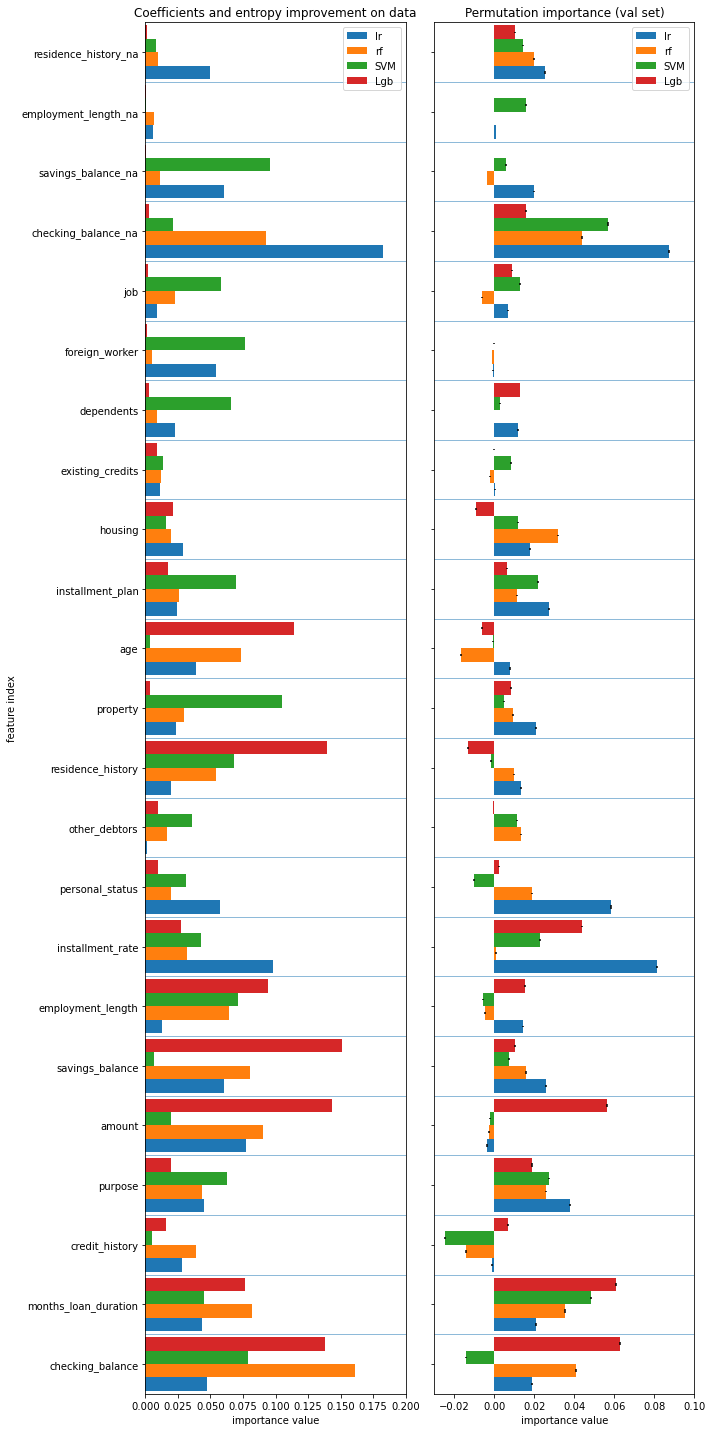

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,20),sharey=True)
plot_importance({'lr': abs(logclf.coef_[0])/abs(logclf.coef_[0]).sum(),'rf':rfclf.feature_importances_,'SVM':abs(np.dot(SVclf.dual_coef_,SVclf.support_vectors_)[0])/abs(np.dot(SVclf.dual_coef_,SVclf.support_vectors_)[0]).sum(),'Lgb':Lgbclf.feature_importances_/Lgbclf.feature_importances_.sum()},features,ax1)
plot_perm_importance({'lr': logclfp['importances_mean'],'rf':rfclfp['importances_mean'] ,'SVM':SVclfp['importances_mean'],'Lgb':Lgbclfp['importances_mean']},[logclfp['importances_std'],rfclfp['importances_std'] ,SVclfp['importances_std'],Lgbclfp['importances_std']],features,ax2)
fig.tight_layout()
plt.show()

In [99]:
for model,result in zip(['LR','RF','SVM','Lgb'],[logclfp,rfclfp ,SVclfp,Lgbclfp]):
    print(f'{model} : {features[np.argsort(result.importances_mean)][:6].tolist()} \n')

LR : ['amount', 'credit_history', 'foreign_worker', 'other_debtors', 'existing_credits', 'employment_length_na'] 

RF : ['age', 'credit_history', 'job', 'employment_length', 'savings_balance_na', 'amount'] 

SVM : ['credit_history', 'checking_balance', 'personal_status', 'employment_length', 'amount', 'residence_history'] 

Lgb : ['residence_history', 'housing', 'age', 'other_debtors', 'savings_balance_na', 'foreign_worker'] 



## Most Negative Examples

## Partial Dependence/Ice-Plots/ALE

In [84]:
from sklearn.inspection import plot_partial_dependence
from pdpbox import pdp
from pycebox.ice import ice, ice_plot
from alibi.explainers import ALE

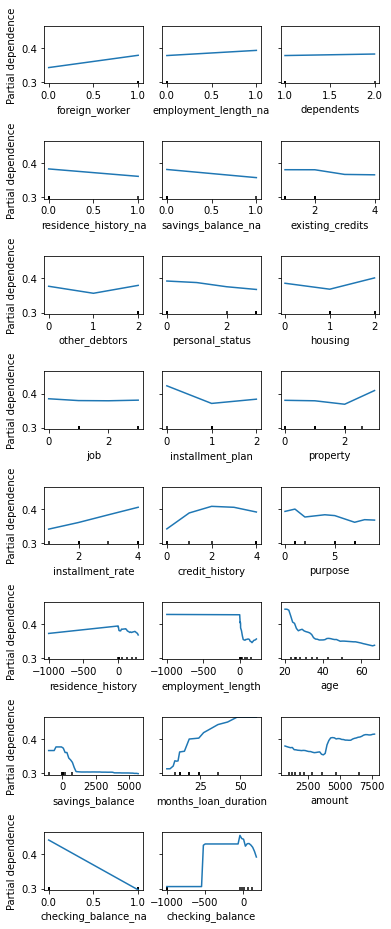

In [113]:
plot_partial_dependence(rfclf, X_rf_val, np.argsort(rfclf.feature_importances_),
                                       feature_names=features, grid_resolution=50)
plt.subplots_adjust(top = 1,bottom=-2,hspace=1 )
fig.tight_layout()

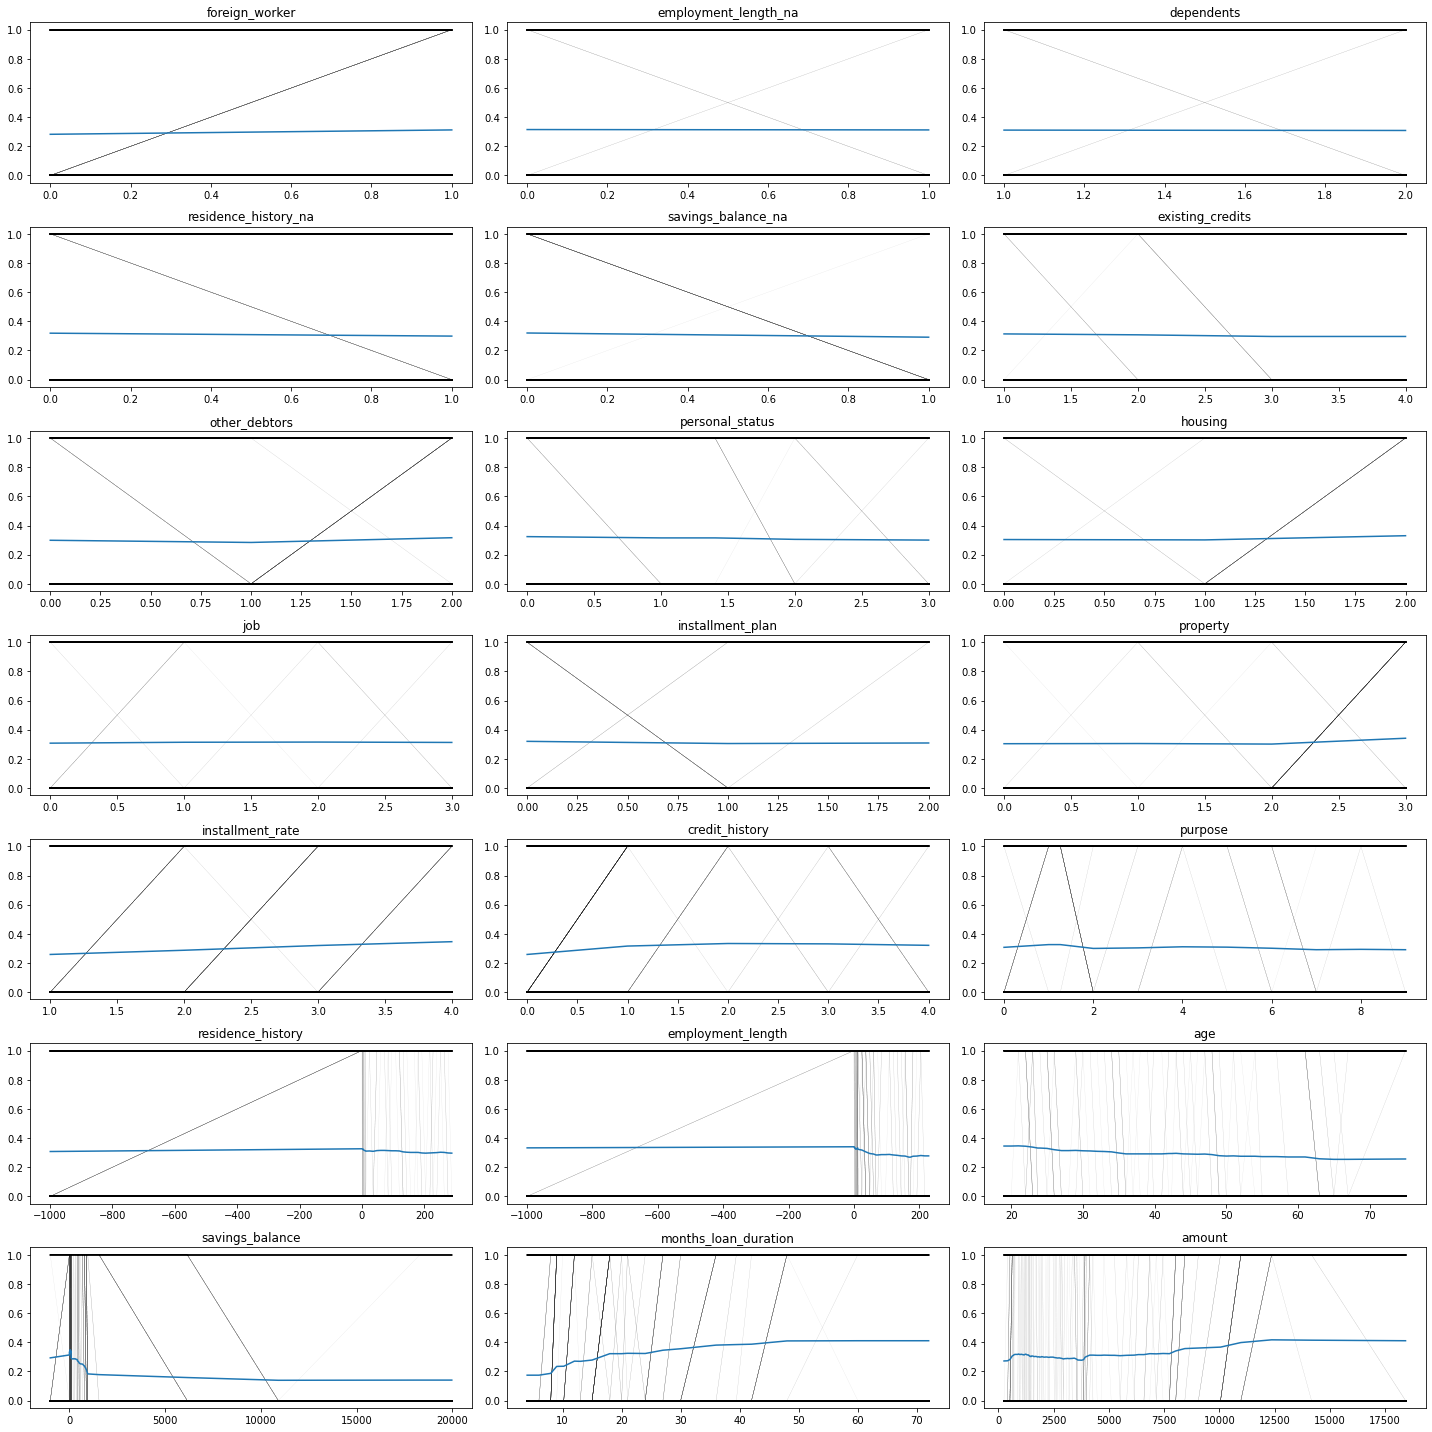

In [126]:
fig, axes = plt.subplots(7, 3, figsize=(20, 20))
for feature, ax in zip(features[np.argsort(rfclf.feature_importances_)], axes.ravel()):
    ice_df = ice(X_rf_train, feature, rfclf.predict, num_grid_points=100)
    ice_plot(ice_df, frac_to_plot=10, plot_pdp=True,
             c='k', alpha=0.1, linewidth=0.3, ax=ax)
    ax.set_title(feature)
# plt.subplots_adjust(top = 1,bottom=-2,hspace=1 )
fig.tight_layout()

In [ ]:
# base_feat = ['N1','C4','C5','N6','N34']
# x=train[train['Dependent_Variable']==1]
# x=train.drop(['Dependent_Variable'],axis=1)

In [ ]:
# def plot_pdp(feat_name, clusters=None):
#     p = pdp.pdp_isolate(t[0], x, feature=feat_name, model_features=x.columns)
#     return pdp.pdp_plot(p, feat_name, plot_lines=True, cluster=clusters is not None,n_cluster_centers=clusters)
# for i in fetures of interest:
#     plot_pdp(i)

In [ ]:
# feature_isolate = pdp.pdp_isolate(gb, pd.DataFrame(X), [0, 1, 2], 1, num_grid_points=100)
# fig, axes = pdp.pdp_plot(feature_isolate, 0, plot_lines=True, frac_to_plot=1)

## Feature Interaction -Hstatistic,vin,pdp

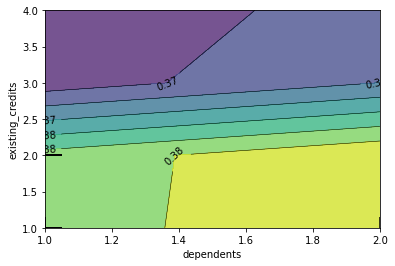

In [111]:
_ = plot_partial_dependence(rfclf, X_rf_val, [np.argsort(rfclf.feature_importances_)[[2,5]]])

In [112]:
# p = pdp.pdp_interact(t[0], x, features=['N1','C4'], model_features=x.columns)
# pdp.pdp_interact_plot(p, ['N1','C4'])

draw decison plot

## Surrogate models-global,Local

## SHAP

In [ ]:
# import shap

# def shap_linear(model, X_train, X_test):
#     linear_explainer = shap.LinearExplainer(model, X_train)
#     shap_values = linear_explainer.shap_values(X_test)
#     s = shap_values.mean(axis=0)
#     s /= np.linalg.norm(s)
#     return s

In [ ]:
# def shap_trees(model, X_train, X_test, approximate=False, tree_limit=None):
#     tree_explainer = shap.TreeExplainer(model, X_train)
#     shap_values = tree_explainer.shap_values(X_test, approximate=approximate, tree_limit=tree_limit)
#     s = shap_values.mean(axis=0)
#     s /= np.linalg.norm(s)
#     return s

In [128]:
# shap_tree_small = shap_trees(best_tree, X_train_small, X_test_small)
# shap_ridge_small = shap_linear(ridge_small, X_train_small, X_test_small)

In [ ]:
# shap.initjs()
# explainer = shap.TreeExplainer(t[0])
# shap_values = explainer.shap_values(valid.drop('Dependent_Variable',axis=1))

In [ ]:
# shap.summary_plot(shap_values,valid.drop('Dependent_Variable',axis=1))

## Example based Explanations

## Anchor/Counterfactuals

In [ ]:
from alibi.utils.data import gen_category_map

In [ ]:
# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions

## prototypes/criticisms

## influential instances

## Feature Creation and Selection

### Categorical Interacion

In [ ]:
# Checking interactions between categorical variables to the dataframe
test_i,valid_i,train_i = test.copy(),train.copy(),valid.copy()
for df in [test_i,valid_i,train_i]:
    interactions = pd.DataFrame(df,index=df.index)
    for col1, col2 in itertools.combinations(cat_features, 2):
        col = '_'.join([col1, col2])
        values = df[col1].map(str) + "_" + df[col2].map(str)
        encoder = preprocessing.LabelEncoder()
        interactions[col] = encoder.fit_transform(values)
    df = df.merge(interactions)

In [ ]:
_ = train_model(train_i,valid_i,test_i)

## Supervised feature selection

In [129]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFpr
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import PolynomialFeatures
from mlxtend.feature_selection import SequentialFeatureSelector

### Univariate Feature Selection

In [ ]:
feature_cols = train.columns.drop('Dependent_Variable')

selector = SelectKBest(f_classif, k=15)
X = selector.fit_transform(train[feature_cols], train['Dependent_Variable'])
selected_features = pd.DataFrame(selector.inverse_transform(X), 
                                    index=train.index, 
                                    columns=feature_cols)

In [ ]:
to_drop = selected_features.columns[selected_features.var() == 0]
_ = train_model(train.drop(to_drop, axis=1), 
                valid.drop(to_drop, axis=1),
                test.drop(to_drop, axis=1))

### Feature selection using regression

In [ ]:
m= SelectFromModel(LogisticRegression(C=0.1, penalty="l1", random_state=23).fit(train[feature_cols], train['Dependent_Variable']), prefit=True)
X = m.transform(train[feature_cols])
selected_features = pd.DataFrame(m.inverse_transform(X), 
                                        index=train.index,
                                        columns=feature_cols)

In [ ]:
to_drop = selected_features.columns[selected_features.var() == 0]
_ = train_model(train.drop(to_drop, axis=1), 
                valid.drop(to_drop, axis=1),
                test.drop(to_drop, axis=1))

### Encoding

In [ ]:
#Count Encoding
count_enc = ce.CountEncoder(cols=cat_features)
count_enc.fit(train[cat_features])

train_e = train.join(count_enc.transform(train[cat_features]).add_suffix('_count'))
valid_e = valid.join(count_enc.transform(valid[cat_features]).add_suffix('_count'))
test_e = test.join(count_enc.transform(test[cat_features]).add_suffix('_count'))

In [ ]:
# Target Encoding
target_enc = ce.TargetEncoder(cols=cat_features)
target_enc.fit(train[cat_features], train['Dependent_Variable'])

train_e = train_e.join(target_enc.transform(train_e[cat_features]).add_suffix('_target'))
valid_e = valid_e.join(target_enc.transform(valid_e[cat_features]).add_suffix('_target'))
test_e = test_e.join(target_enc.transform(test_e[cat_features]).add_suffix('_target'))

In [ ]:
#Catboost encoding
cb_enc = ce.CatBoostEncoder(cols=cat_features, random_state=7)
cb_enc.fit(train[cat_features], train['Dependent_Variable'])

train_e = train_e.join(cb_enc.transform(train_e[cat_features]).add_suffix('_cb'))
valid_e  = valid_e.join(cb_enc.transform(valid_e[cat_features]).add_suffix('_cb'))
test_e = test_e.join(cb_enc.transform(test_e[cat_features]).add_suffix('_cb'))

### USING PCA

## Adversarial Validation

# Inference Based Experiments 

## Clustering(KNN with CBO,Agglomerative Clustering)

In [ ]:
correlations = np.round(sc.stats.spearmanr(train.drop('Dependent_Variable',axis=1)).correlation, 4)
correlation_condensed = hc.distance.squareform(1-correlations)
z = hc.linkage(correlation_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=train.drop('Dependent_Variable',axis=1).columns, orientation='left', leaf_font_size=8,show_contracted=True)
plt.show()

In [ ]:
plt.figure(figsize=(16,10))
corr = train.drop('Dependent_Variable',axis=1).corr()
sns.heatmap(corr, cmap='RdBu_r', center=0.0) 
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical', fontsize=8);
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=8);
plt.show()

## Bayesian Models

### Bayesian Models with conditional independence

In [85]:
def scale(x):
    for col in x.select_dtypes('float'):
        mean,std = x[col].mean(),x[col].std()
        x[col] = (x[col]-mean)/std
    return x
        
def Prob_sum(x,x_sort,y,std,c=y_train.mean()):
    left = x - std/c
    right = x + std/c
    p_left = np.searchsorted(x_sort,left)
    p_right = np.searchsorted(x_sort,right)
    p_right[p_right>=y.shape[0]] = y.shape[0]-1
    p_left[p_left>=y.shape[0]] = y.shape[0]-1
    return (y[p_right]-y[p_left])

def get_pdf(train,col):
    std = tr[col].std()
    df = train.groupby(col).agg({'default':['sum','count']})
    cols = ['sum_y','count_y']
    df.columns = cols
    df = df.reset_index().sort_values(col)
    y,c = cols

    df[y] = df[y].cumsum()
    df[c] = df[c].cumsum()

    dg = pd.DataFrame()
    tm = Prob_sum(np.linspace(-5, 5, 501),df[col].values,df[y].values,std) #z-score== (x - var_mean) / (var_standard_deviation)
    cm = Prob_sum(np.linspace(-5, 5, 501),df[col].values,df[c].values,std)+1
    dg['residual'] = tm/cm

    return dg['residual'].values

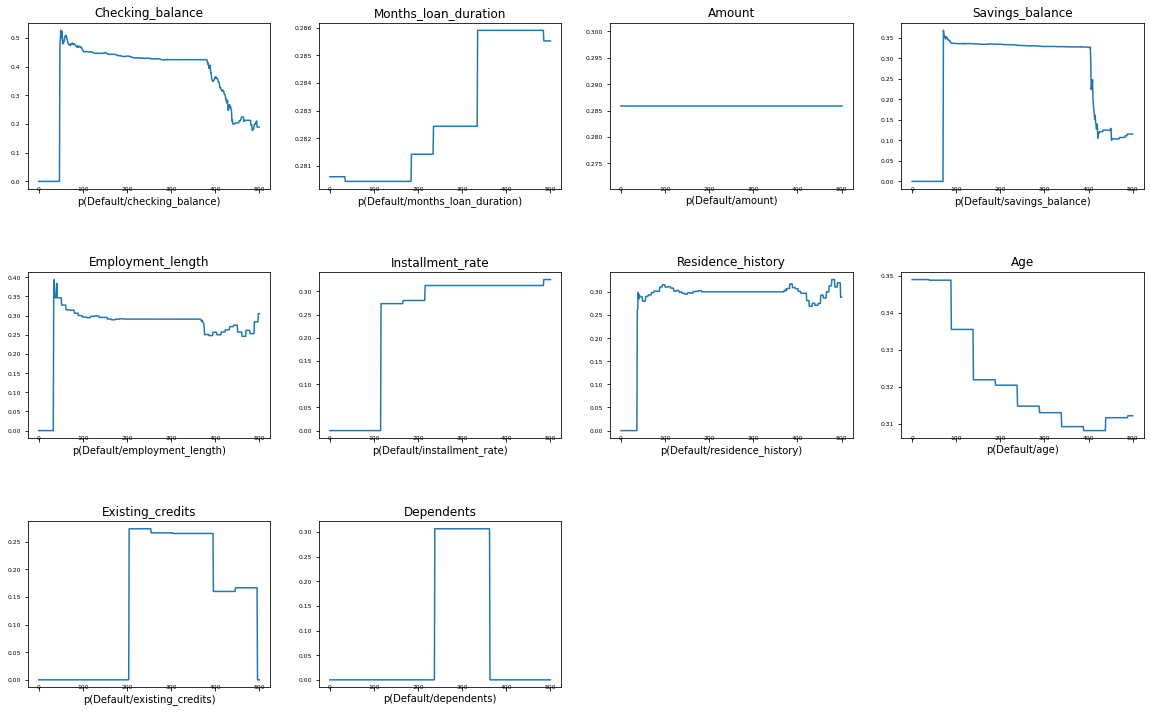

In [94]:
plt.figure(figsize = (20, 16))
tr = X_train.join(y_train).copy()
tr = scale(tr)
for i, col in enumerate(X_train.select_dtypes(['float','int'])):
    ax = plt.subplot(9, 4, i + 1)
    prob = get_pdf(tr,col)
    plt.plot(prob)
    plt.title(f'{col.capitalize()}'); plt.xlabel(f'p(Default/{col})');
    plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
    plt.tick_params(axis='y', which='major', labelsize=6)
    locs, labels = plt.xticks()
plt.subplots_adjust(top = 2, hspace=.5 )

## DNN

### Understand NN embeddings 

In [ ]:
## Do NNs have similar data?
In [93]:

from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(y_val_embed)
distances, indices = nbrs.kneighbors(y_val_embed)


### TSNE

In [ ]:
from sklearn.manifold import TSNE


tsne = TSNE(
    perplexity=20.0,
)


y_val_proj = tsne.fit_transform(y_val_embed)


fig, ax = plt.subplots()
colors = ['tab:red' if y else 'tab:blue' for y in df_val[target].values]
labels = ['Fraud' if y else 'Legit' for y in df_val[target].values]
ax.scatter(x=y_val_proj[:,0], y=y_val_proj[:,1], c=colors, s=1, alpha=0.5)
ax.grid()

_ = ax.set_title('TSNE Projection of LightGMB Embeddings')


# GAM's and EBM

### Modifying a PyGAM model based on distributuion Inference

In [ ]:
from pygam import LogisticGAM, s, f
from pygam.datasets import default

X, y = default(return_X_y=True)

gam = LogisticGAM(f(0) + s(1) + s(2)).gridsearch(X, y)

fig, axs = plt.subplots(1, 3)
titles = ['student', 'balance', 'income']

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);


In [12]:
y_train.mean()

0.3